In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
import omnivida_loader as ov
import statsmodels.api         as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Let's start by loading the cleansed datasets into pandas DataFrames. 

In [2]:
adherence, adherence_change = ov.get_adherence_dataset()
basic_info = ov.get_basic_info_dataset()
familiar_records = ov.get_family_records_dataset()
life_quality = ov.get_wellbeing_index_dataset()

### Basic personal data

In [3]:
basic_info.head()

,id_paciente,edad,genero,escolaridad,estado_civil,departamento,ciudad,estrato_social,zona,acompanante,nivel_socioeconomico,ocupacion,regimen,tipo_afiliacion,relacion_laboral,fecha_nacimiento
0,500547,58.0,M,SECUNDARIA,CASADO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19
1,500588,15.0,M,PRIMARIA,SOLTERO (A),SANTAFE DE BOGOTA D.C,BOGOTA,2.0,URBANA,MADRE,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19
2,502989,29.0,M,UNIVERSITARIO,SOLTERO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22
3,506808,11.0,M,EDAD PREESCOLAR,SOLTERO (A),ANTIOQUIA,BELLO,1.0,URBANA,MADRE,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06
4,512938,22.0,F,SECUNDARIA,SOLTERO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15


In [4]:
basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 16 columns):
id_paciente             872 non-null int64
edad                    872 non-null float64
genero                  870 non-null category
escolaridad             862 non-null category
estado_civil            872 non-null category
departamento            872 non-null object
ciudad                  872 non-null object
estrato_social          872 non-null float64
zona                    872 non-null category
acompanante             850 non-null object
nivel_socioeconomico    860 non-null category
ocupacion               872 non-null category
regimen                 850 non-null category
tipo_afiliacion         850 non-null category
relacion_laboral        852 non-null category
fecha_nacimiento        872 non-null datetime64[ns]
dtypes: category(9), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 57.3+ KB


In [5]:
basic_info.describe(include='all')

,id_paciente,edad,genero,escolaridad,estado_civil,departamento,ciudad,estrato_social,zona,acompanante,nivel_socioeconomico,ocupacion,regimen,tipo_afiliacion,relacion_laboral,fecha_nacimiento
count,8.720000e+02,872.000000,870,862,872,872,872,872.000000,872,850,860,872,850,850,852,872
unique,NaN,NaN,2,8,6,11,52,NaN,2,10,6,8,4,3,5,858
top,NaN,NaN,F,SECUNDARIA,SOLTERO (A),ANTIOQUIA,MEDELLIN,NaN,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1984-05-28 00:00:00
freq,NaN,NaN,604,384,410,699,464,NaN,839,527,629,457,826,532,471,2
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1932-04-05 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-04 00:00:00
mean,1.259526e+06,41.146789,NaN,NaN,NaN,NaN,NaN,2.983945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.343817e+05,18.222354,NaN,NaN,NaN,NaN,NaN,0.865047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.005470e+05,5.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.887368e+05,27.000000,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's define a new variable called `grupo_edad` (age group), to process age as a categorial variable:

In [6]:
basic_info['grupo_edad'] = basic_info['edad'].apply(lambda x: np.ceil(x/10.))

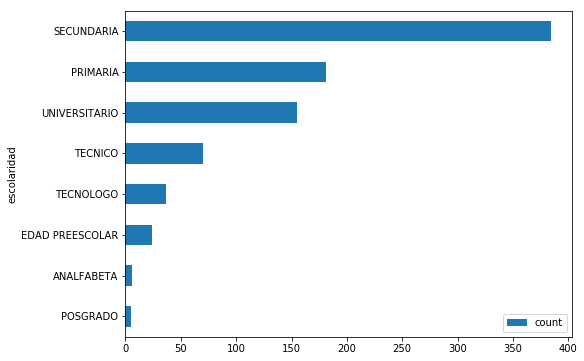

In [7]:
escolaridad = basic_info[['id_paciente', 'escolaridad']].groupby('escolaridad').size().sort_values(ascending=False).reset_index(name='count')
escolaridad.sort_values(by='count', ascending=True).plot(kind='barh', x='escolaridad', figsize=(8,6))

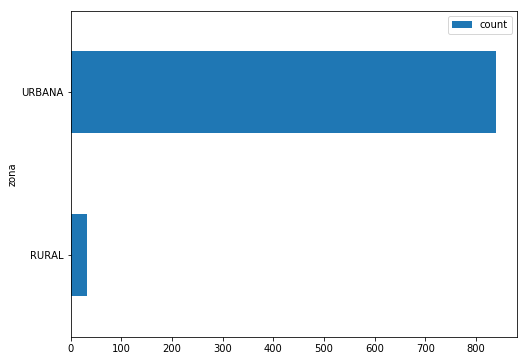

In [148]:
zona = basic_info[['id_paciente', 'zona']].groupby('zona').size().sort_values(ascending=False).reset_index(name='count')
zona.sort_values(by='count', ascending=True).plot(kind='barh', x='zona', figsize=(8,6))

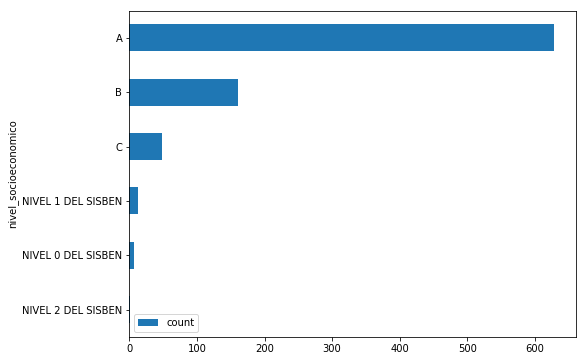

In [149]:
nivel_socioeconomico = basic_info[['id_paciente', 'nivel_socioeconomico']].groupby('nivel_socioeconomico').size().sort_values(ascending=False).reset_index(name='count')
nivel_socioeconomico.sort_values(by='count', ascending=True).plot(kind='barh', x='nivel_socioeconomico', figsize=(8,6))

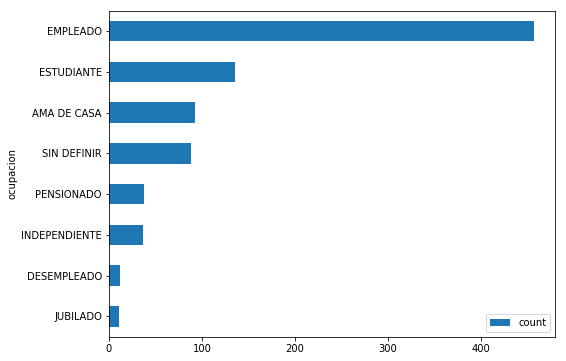

In [150]:
ocupacion = basic_info[['id_paciente', 'ocupacion']].groupby('ocupacion').size().sort_values(ascending=False).reset_index(name='count')
ocupacion.sort_values(by='count', ascending=True).plot(kind='barh', x='ocupacion', figsize=(8,6))

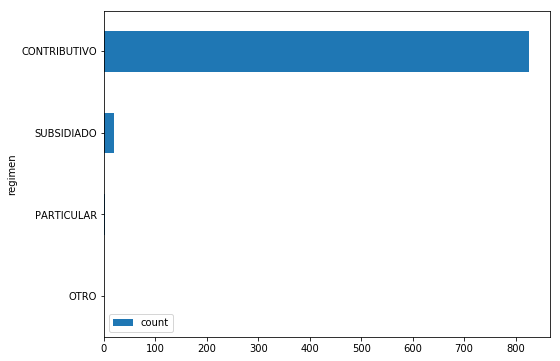

In [151]:
regimen = basic_info[['id_paciente', 'regimen']].groupby('regimen').size().sort_values(ascending=False).reset_index(name='count')
regimen.sort_values(by='count', ascending=True).plot(kind='barh', x='regimen', figsize=(8,6))

In [7]:
adherence.head()

,id,fe_entrevista,morisky_green,smaq1,smaq2,espa,nm_espa,cualitativo_ponderado,cuantitativo_ponderado,categoria
0,500547,2016-07-11,1,1,4,1,6.0,1,4,A
1,500547,2019-03-14,1,1,4,1,6.0,1,4,A
2,500547,2019-10-11,1,1,4,1,6.0,1,4,A
3,500547,2019-12-09,1,1,4,1,6.0,1,4,A
4,500547,2020-01-16,1,1,4,1,6.0,1,4,A


In [8]:
adherence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 10 columns):
id                        4773 non-null int64
fe_entrevista             4773 non-null datetime64[ns]
morisky_green             4773 non-null int64
smaq1                     4773 non-null int64
smaq2                     4773 non-null int64
espa                      4773 non-null int64
nm_espa                   4773 non-null float64
cualitativo_ponderado     4773 non-null int64
cuantitativo_ponderado    4773 non-null int64
categoria                 4773 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), int64(7)
memory usage: 340.5 KB


In [9]:
adherence.describe(include='all')

,id,fe_entrevista,morisky_green,smaq1,smaq2,espa,nm_espa,cualitativo_ponderado,cuantitativo_ponderado,categoria
count,4.773000e+03,4773,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773
unique,NaN,1433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,2019-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2317
first,NaN,2012-04-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.238178e+06,NaN,0.848942,0.836162,3.774356,0.830086,5.602975,0.793002,3.774356,NaN
std,4.296392e+05,NaN,0.358143,0.370168,0.799201,0.375597,0.911489,0.405196,0.799201,NaN
min,5.005470e+05,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,8.716330e+05,NaN,1.000000,1.000000,4.000000,1.000000,5.000000,1.000000,4.000000,NaN


,id,count_records
0,1769865,41
1,979605,30
2,1132214,28
3,622031,27
4,1676414,26
5,1196034,25
6,916510,25
7,1536265,23
8,1828862,23
9,1399081,23


4773


Text(0.5,1,'Number of adherence records per patient')

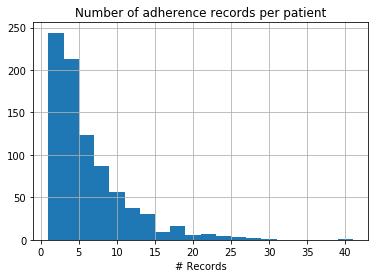

In [10]:
num_records_per_patient = adherence.groupby('id').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_patient.head(10))
print(sum(num_records_per_patient['count_records']))
num_records_per_patient.hist('count_records', bins=20)
plt.xlabel('# Records')
plt.title('Number of adherence records per patient')

,categoria,count_records
0,A,2317
1,M,1285
2,A-,689
3,N+,472
4,N,10


4773


Text(0.5,1,'Number records per category')

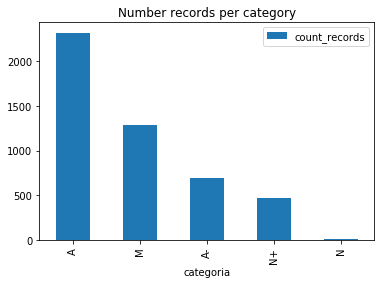

In [11]:
num_records_per_category = adherence.groupby('categoria').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_category)
print(sum(num_records_per_category['count_records']))
num_records_per_category.plot(kind='bar', x='categoria')
# plt.xlabel('# Records')
plt.title('Number records per category')

In [12]:
adherence_pivot = adherence.copy()
adherence_pivot['mes_entrevista'] = adherence_pivot['fe_entrevista'].dt.month
adherence_pivot['anio_entrevista'] = adherence_pivot['fe_entrevista'].dt.year
adherence_pivot_cuantitativo = pd.pivot_table(adherence_pivot, values='cuantitativo_ponderado', index='mes_entrevista', columns='anio_entrevista', aggfunc='mean')
adherence_pivot_cualitativo = pd.pivot_table(adherence_pivot, values='cualitativo_ponderado', index='mes_entrevista', columns='anio_entrevista', aggfunc='sum')
adherence_pivot_enrevistas = pd.pivot_table(adherence_pivot, values='id', index='mes_entrevista', columns='anio_entrevista', aggfunc='count')

Text(0.5,1,'Reportes de adherencia')

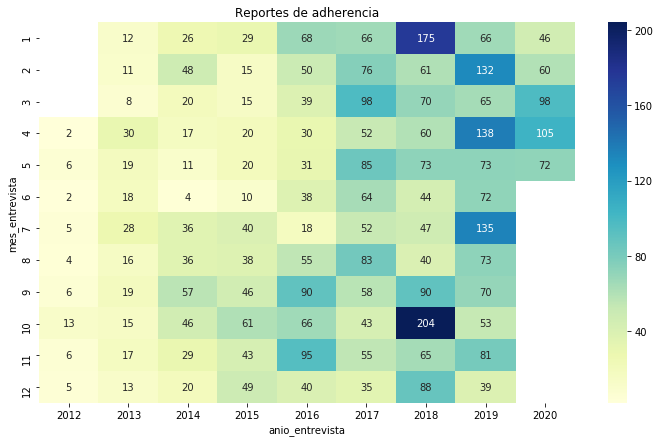

In [13]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_enrevistas, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Reportes de adherencia')

Text(0.5,1,'Number of adherent patients per month')

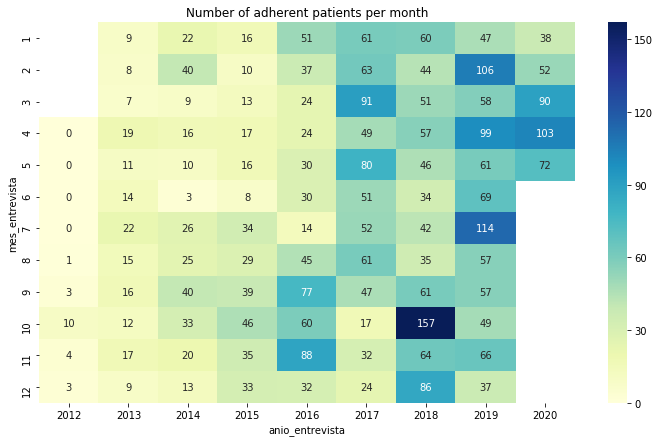

In [14]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cualitativo, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Number of adherent patients per month')

Text(0.5,1,'Percentage of adherent patients per month')

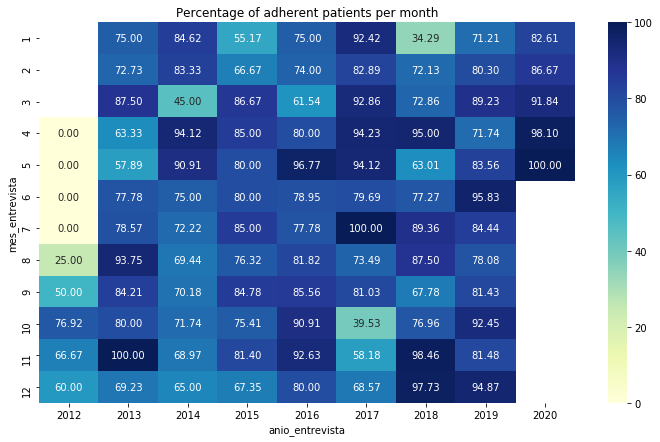

In [15]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(100*(adherence_pivot_cualitativo/adherence_pivot_enrevistas), ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Percentage of adherent patients per month')

Text(0.5,1,'Average adherence score per month')

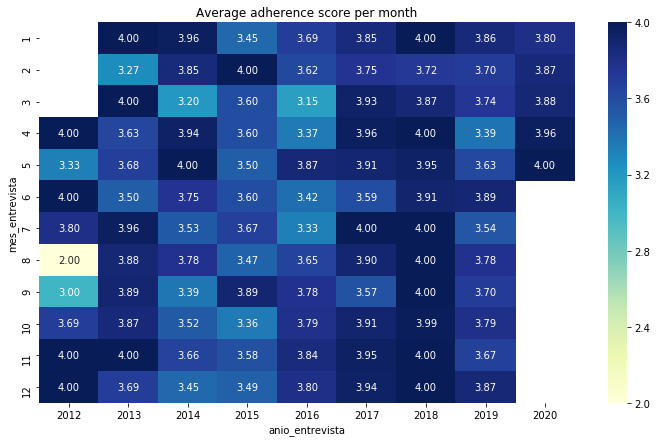

In [16]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cuantitativo, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Average adherence score per month')

Text(0.5,1,'Median adherence (qualitative) score per month')

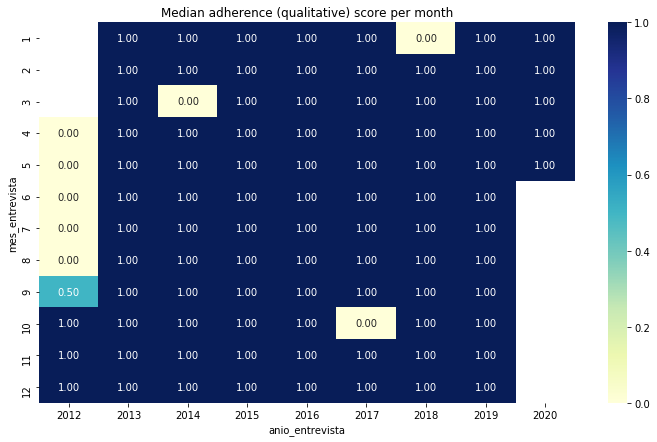

In [17]:
adherence_pivot_cualitativo2 = pd.pivot_table(adherence_pivot, values='cualitativo_ponderado', index='mes_entrevista', columns='anio_entrevista', aggfunc='median')
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cualitativo2, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Median adherence (qualitative) score per month')

In [18]:
adherence_change.head(10)

,id,fe_entrevista,morisky_green,smaq1,smaq2,espa,nm_espa,cualitativo_ponderado,cuantitativo_ponderado,categoria,morisky_change,smaq1_change,smaq2_change,espa_change,nm_espa_change,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia
0,500547,2016-07-11,1,1,4,1,6.0,1,4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
1,500547,2019-03-14,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,976.0,100.0
2,500547,2019-10-11,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.0,100.0
3,500547,2019-12-09,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,100.0
4,500547,2020-01-16,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,100.0
5,500547,2020-03-25,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,100.0
6,500547,2020-05-08,1,1,4,1,5.0,1,4,A,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,44.0,100.0
7,500588,2019-04-26,1,1,4,1,6.0,1,4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
8,502989,2014-08-22,0,0,2,1,5.0,0,2,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,502989,2014-10-28,0,0,2,0,5.0,0,2,M,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,67.0,0.0


In [19]:
select_fields = ['id', 'fe_entrevista', 'categoria', 'cualitativo_ponderado', 'cuantitativo_ponderado', 'cualitativo_ponderado_change', 'cuantitativo_ponderado_change', 'dias_ultimo_control', 'historico_porcentaje_adherencia']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

,id,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia
0,500547,2016-07-11,A,1,4,NaN,NaN,NaN,100.00
1,500547,2019-03-14,A,1,4,0.0,0.0,976.0,100.00
2,500547,2019-10-11,A,1,4,0.0,0.0,211.0,100.00
3,500547,2019-12-09,A,1,4,0.0,0.0,59.0,100.00
4,500547,2020-01-16,A,1,4,0.0,0.0,38.0,100.00
5,500547,2020-03-25,A,1,4,0.0,0.0,69.0,100.00
6,500547,2020-05-08,A,1,4,0.0,0.0,44.0,100.00
7,500588,2019-04-26,A,1,4,NaN,NaN,NaN,100.00
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.00
9,502989,2014-10-28,M,0,2,0.0,0.0,67.0,0.00


In [20]:
adherence_change_analysis_pivot = adherence_change_analysis.copy()
adherence_change_analysis_pivot['mes_entrevista'] = adherence_change_analysis_pivot['fe_entrevista'].dt.month
adherence_change_analysis_pivot['anio_entrevista'] = adherence_change_analysis_pivot['fe_entrevista'].dt.year
adherence_pivot_dias_control = pd.pivot_table(adherence_change_analysis_pivot, values='dias_ultimo_control', index='mes_entrevista', columns='anio_entrevista', aggfunc='mean')
adherence_pivot_adher_percentage = pd.pivot_table(adherence_change_analysis_pivot, values='historico_porcentaje_adherencia', index='mes_entrevista', columns='anio_entrevista', aggfunc='mean')

Text(0.5,1,'Dias desde el ultimo control')

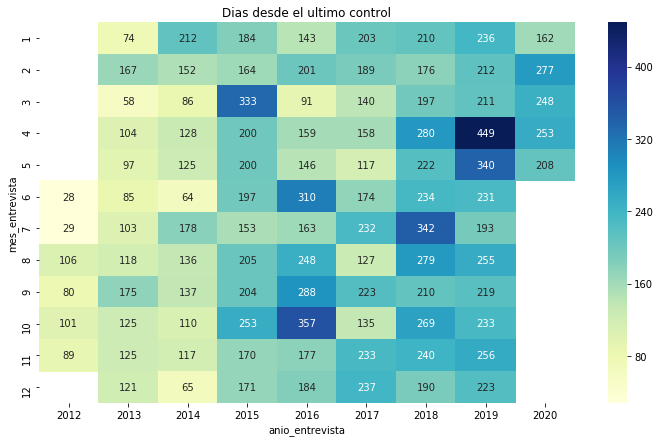

In [21]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_dias_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Dias desde el ultimo control')

Text(0.5,1,'Porcentage de adherencia historico promedio por mes')

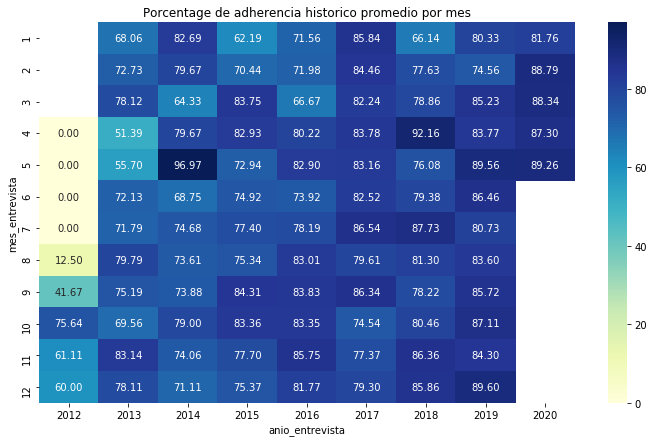

In [22]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_adher_percentage, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Porcentage de adherencia historico promedio por mes')

#### Let's have a look at those patients that went from `adherent` (i.e. 1 in the `cualitativo_ponderado` field) to `non-adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [23]:
neg_transition = adherence_change_analysis[adherence_change_analysis['cualitativo_ponderado_change']==-1]
neg_transition.head(10)

,id,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia
14,502989,2016-01-12,M,0,3,-1.0,-1.0,201.0,14.29
16,502989,2017-01-03,M,0,3,-1.0,-1.0,354.0,22.22
20,502989,2018-10-03,M,0,4,-1.0,0.0,421.0,38.46
35,506808,2018-10-08,M,0,4,-1.0,0.0,131.0,85.71
44,512938,2018-05-04,M,0,4,-1.0,0.0,216.0,85.71
48,512938,2019-09-30,M,0,1,-1.0,-3.0,293.0,72.73
51,514102,2018-01-30,A,0,4,-1.0,0.0,74.0,66.67
55,524006,2015-10-13,A-,0,4,-1.0,0.0,33.0,66.67
62,524006,2017-05-10,A-,0,3,-1.0,-1.0,28.0,70.00
93,529410,2018-01-30,A-,0,4,-1.0,0.0,122.0,66.67


In [24]:
neg_transition_count = neg_transition.groupby('id').size().sort_values(ascending=False).reset_index(name='count_neg_transitions')
neg_transition_count.head(10)

,id,count_neg_transitions
0,1769865,7
1,832593,7
2,622031,6
3,739693,6
4,673765,6
5,916510,6
6,1828862,5
7,1132214,5
8,747471,5
9,801004,5


Text(0.5,1,'Number of negative transitions per month')

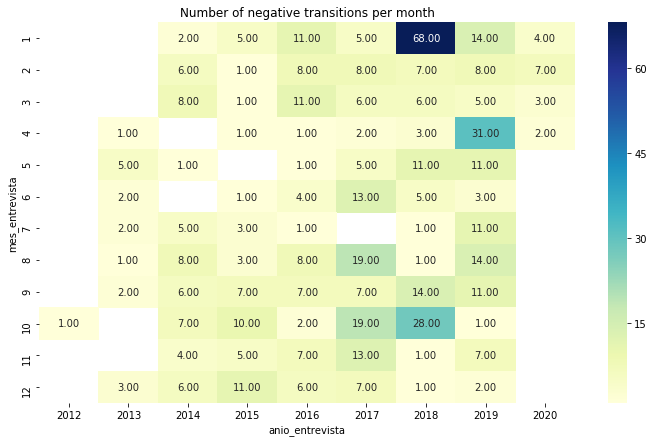

In [25]:
neg_transition_pivot = neg_transition.copy()
neg_transition_pivot['mes_entrevista'] = neg_transition_pivot['fe_entrevista'].dt.month
neg_transition_pivot['anio_entrevista'] = neg_transition_pivot['fe_entrevista'].dt.year
neg_transition_pivot = pd.pivot_table(neg_transition_pivot, values='id', index='mes_entrevista', columns='anio_entrevista', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(neg_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of negative transitions per month')

#### Let's have a look at those patients that went from `non-adherent` (i.e. 0 in the `cualitativo_ponderado` field) to `adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [26]:
pos_transition = adherence_change_analysis[adherence_change_analysis['cualitativo_ponderado_change']==1]
pos_transition.head(10)

,id,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia
13,502989,2015-06-25,M,1,4,1.0,1.0,162.0,16.67
15,502989,2016-01-15,M,1,4,1.0,1.0,3.0,25.00
17,502989,2017-03-21,M,1,4,1.0,1.0,77.0,30.00
21,502989,2019-02-08,M,1,4,1.0,0.0,128.0,42.86
23,506808,2013-05-24,M,1,4,1.0,0.0,16.0,50.00
37,506808,2019-06-14,M,1,4,1.0,4.0,113.0,81.25
46,512938,2018-11-14,M,1,4,1.0,0.0,42.0,77.78
52,514102,2018-09-25,A,1,4,1.0,0.0,238.0,75.00
57,524006,2016-06-02,A-,1,4,1.0,0.0,206.0,60.00
63,524006,2017-07-28,A-,1,4,1.0,1.0,79.0,72.73


In [27]:
pos_transition_count = pos_transition.groupby('id').size().sort_values(ascending=False).reset_index(name='count_pos_transitions')
pos_transition_count.head(10)

,id,count_pos_transitions
0,1769865,8
1,832593,7
2,622031,7
3,673765,6
4,739693,6
5,1132214,6
6,747471,5
7,1399081,5
8,916510,5
9,801004,5


Text(0.5,1,'Number of positive transitions per month')

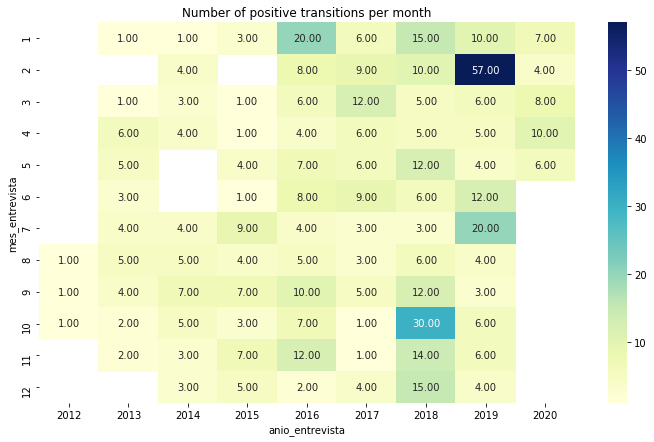

In [28]:
pos_transition_pivot = pos_transition.copy()
pos_transition_pivot['mes_entrevista'] = pos_transition_pivot['fe_entrevista'].dt.month
pos_transition_pivot['anio_entrevista'] = pos_transition_pivot['fe_entrevista'].dt.year
pos_transition_pivot = pd.pivot_table(pos_transition_pivot, values='id', index='mes_entrevista', columns='anio_entrevista', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(pos_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of positive transitions per month')

#### Let's study the influence of some demographic factors on the adherence (age, education, gender, socioeconomic status, zone, employment type)

In [29]:
basic_info_adherence = adherence_change_analysis.merge(basic_info, how='left', right_on='id_paciente', left_on='id').drop('id', axis=1)
basic_info_adherence['categoria'] = basic_info_adherence['categoria'].astype('category')
basic_info_adherence['categoria'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
basic_info_adherence['edad_entrevista'] = (np.ceil((basic_info_adherence['fe_entrevista'] - basic_info_adherence['fecha_nacimiento']) / np.timedelta64(1, 'Y'))).astype(int)

In [30]:
basic_info_adherence.head(20)

,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia,id_paciente,edad,...,zona,acompanante,nivel_socioeconomico,ocupacion,regimen,tipo_afiliacion,relacion_laboral,fecha_nacimiento,grupo_edad,edad_entrevista
0,2016-07-11,A,1,4,NaN,NaN,NaN,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,55
1,2019-03-14,A,1,4,0.0,0.0,976.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,57
2,2019-10-11,A,1,4,0.0,0.0,211.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
3,2019-12-09,A,1,4,0.0,0.0,59.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
4,2020-01-16,A,1,4,0.0,0.0,38.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
5,2020-03-25,A,1,4,0.0,0.0,69.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
6,2020-05-08,A,1,4,0.0,0.0,44.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
7,2019-04-26,A,1,4,NaN,NaN,NaN,100.00,500588,15.0,...,URBANA,MADRE,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19,2.0,15
8,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25


1. Adherence vs. Age

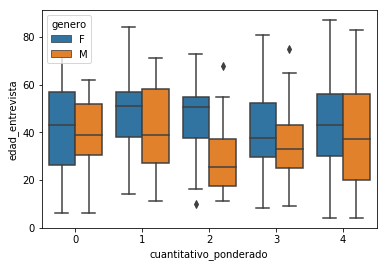

In [31]:
sns.boxplot(data=basic_info_adherence, x='cuantitativo_ponderado', y='edad_entrevista', hue='genero')

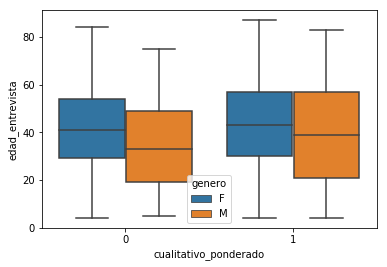

In [32]:
sns.boxplot(data=basic_info_adherence, x='cualitativo_ponderado', y='edad_entrevista', hue='genero')

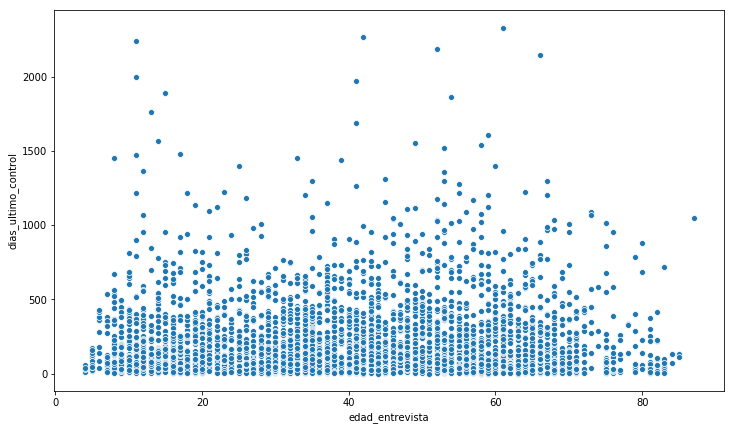

In [33]:
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(data=basic_info_adherence, x='edad_entrevista', y='dias_ultimo_control', ax=ax)

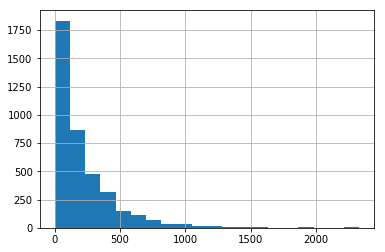

In [34]:
basic_info_adherence['dias_ultimo_control'].hist(bins=20)

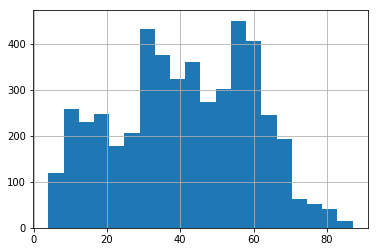

In [35]:
basic_info_adherence['edad_entrevista'].hist(bins=20)

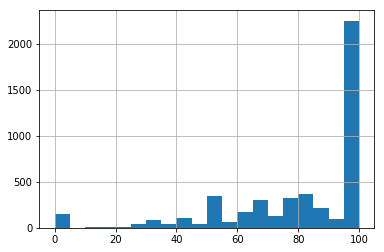

In [36]:
basic_info_adherence['historico_porcentaje_adherencia'].hist(bins=20)

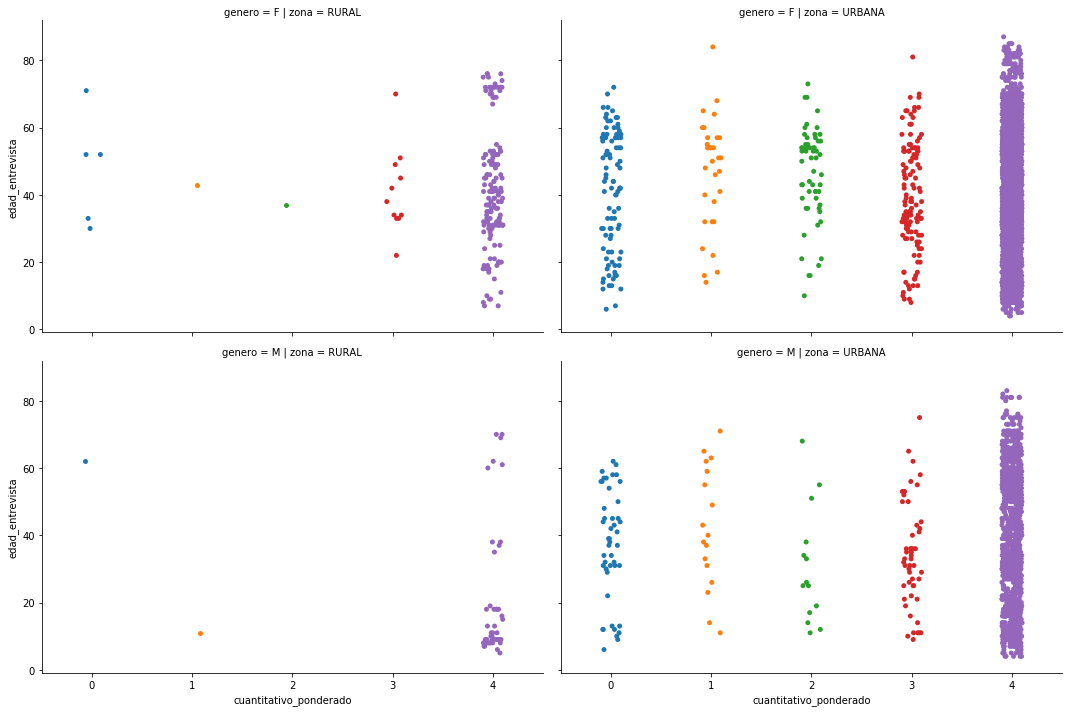

In [37]:
sns.catplot(data=basic_info_adherence, y="edad_entrevista", x="cuantitativo_ponderado", col='zona', row='genero',
            height=5, aspect=1.5)

Text(0.5,1,'Age vs Adherence category')

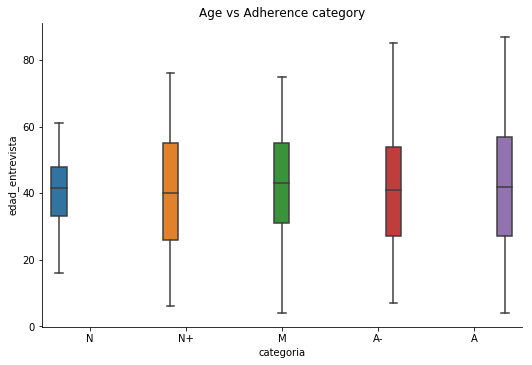

In [38]:
sns.catplot(data=basic_info_adherence, y="edad_entrevista", x="categoria", hue="categoria",#, col='zona', row='genero',
            kind='box', height=5, aspect=1.5)
plt.title("Age vs Adherence category")

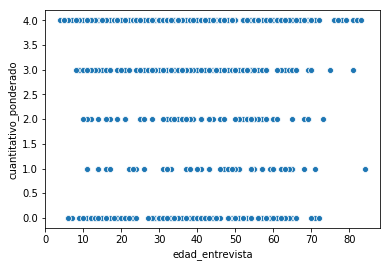

In [39]:
sns.scatterplot(x='edad_entrevista', y='cuantitativo_ponderado', data=basic_info_adherence[basic_info_adherence['cualitativo_ponderado']==0])

In [40]:
basic_info_non_adherent_patients = basic_info_adherence[(basic_info_adherence['cuantitativo_ponderado'] < 4) & (basic_info_adherence['cualitativo_ponderado']==0)]
basic_info_non_adherent_patients

,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia,id_paciente,edad,...,zona,acompanante,nivel_socioeconomico,ocupacion,regimen,tipo_afiliacion,relacion_laboral,fecha_nacimiento,grupo_edad,edad_entrevista
8,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
11,2015-01-07,M,0,3,0.0,-1.0,47.0,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
12,2015-01-14,M,0,3,0.0,0.0,7.0,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
14,2016-01-12,M,0,3,-1.0,-1.0,201.0,14.29,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26
16,2017-01-03,M,0,3,-1.0,-1.0,354.0,22.22,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,27
36,2019-02-21,M,0,0,0.0,-4.0,136.0,80.00,506808,11.0,...,URBANA,MADRE,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06,2.0,11
48,2019-09-30,M,0,1,-1.0,-3.0,293.0,72.73,512938,22.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15,3.0,22
62,2017-05-10,A-,0,3,-1.0,-1.0,28.0,70.00,524006,67.0,...,URBANA,HIJO(A),A,PENSIONADO,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1952-08-10,7.0,65
94,2019-02-14,A-,0,3,0.0,-1.0,380.0,57.14,529410,22.0,...,RURAL,MADRE,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,1998-01-21,3.0,22


In [41]:
basic_info_adherent_patients = basic_info_adherence[(basic_info_adherence['cuantitativo_ponderado'] == 4) & (basic_info_adherence['cualitativo_ponderado']==1)]
basic_info_adherent_patients

,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia,id_paciente,edad,...,zona,acompanante,nivel_socioeconomico,ocupacion,regimen,tipo_afiliacion,relacion_laboral,fecha_nacimiento,grupo_edad,edad_entrevista
0,2016-07-11,A,1,4,NaN,NaN,NaN,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,55
1,2019-03-14,A,1,4,0.0,0.0,976.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,57
2,2019-10-11,A,1,4,0.0,0.0,211.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
3,2019-12-09,A,1,4,0.0,0.0,59.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
4,2020-01-16,A,1,4,0.0,0.0,38.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
5,2020-03-25,A,1,4,0.0,0.0,69.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
6,2020-05-08,A,1,4,0.0,0.0,44.0,100.00,500547,58.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
7,2019-04-26,A,1,4,NaN,NaN,NaN,100.00,500588,15.0,...,URBANA,MADRE,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19,2.0,15
13,2015-06-25,M,1,4,1.0,1.0,162.0,16.67,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
15,2016-01-15,M,1,4,1.0,1.0,3.0,25.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26


In [42]:
adherence[adherence['id']==1012279]

,id,fe_entrevista,morisky_green,smaq1,smaq2,espa,nm_espa,cualitativo_ponderado,cuantitativo_ponderado,categoria
1666,1012279,2018-07-27,1,1,4,1,6.0,1,4,M
1667,1012279,2019-06-11,0,0,3,1,5.0,0,3,M
1668,1012279,2019-07-16,1,1,4,1,6.0,1,4,M
1669,1012279,2020-02-22,1,1,4,0,5.0,0,4,M


In [43]:
corr_basic_info_adherence = basic_info_adherence.loc[:, ~basic_info_adherence.columns.isin(['id_paciente', 'edad', 'grupo_edad'])].corr()

Text(0.5,1,'Correlation Matrix')

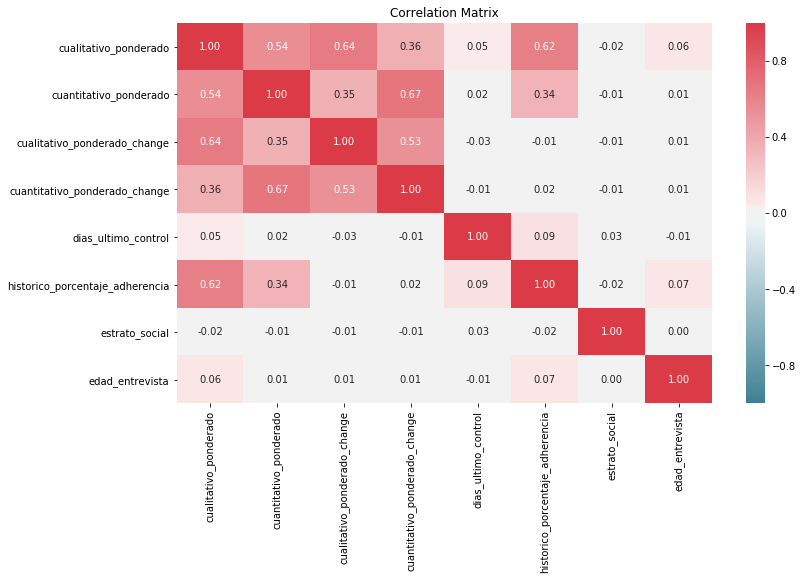

In [44]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_adherence, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [45]:
corr_basic_info_non_adherent = basic_info_non_adherent_patients.loc[:, ~basic_info_non_adherent_patients.columns.isin(['id_paciente', 'edad', 'grupo_edad'])].corr()

Text(0.5,1,'Correlation Matrix')

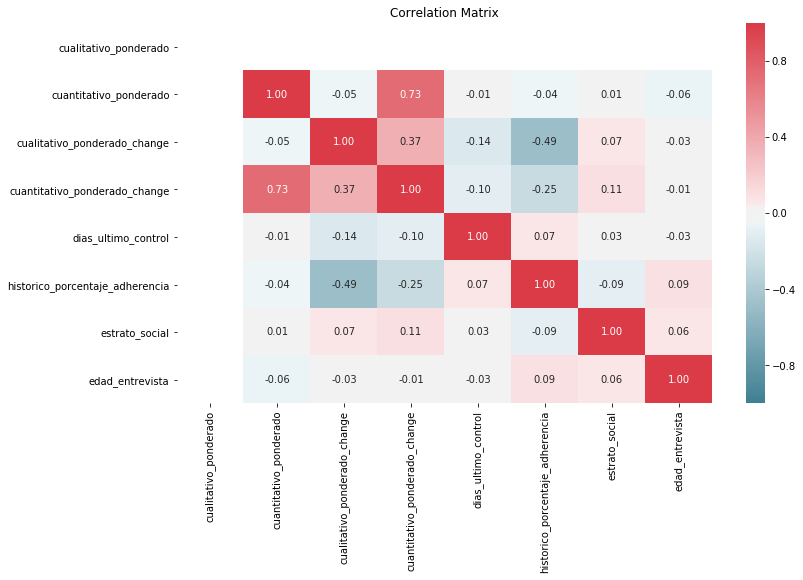

In [46]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_non_adherent, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [47]:
corr_basic_info_adherent_patients = basic_info_adherent_patients.loc[:, ~basic_info_adherent_patients.columns.isin(['id_paciente', 'edad', 'grupo_edad'])].corr()

Text(0.5,1,'Correlation Matrix')

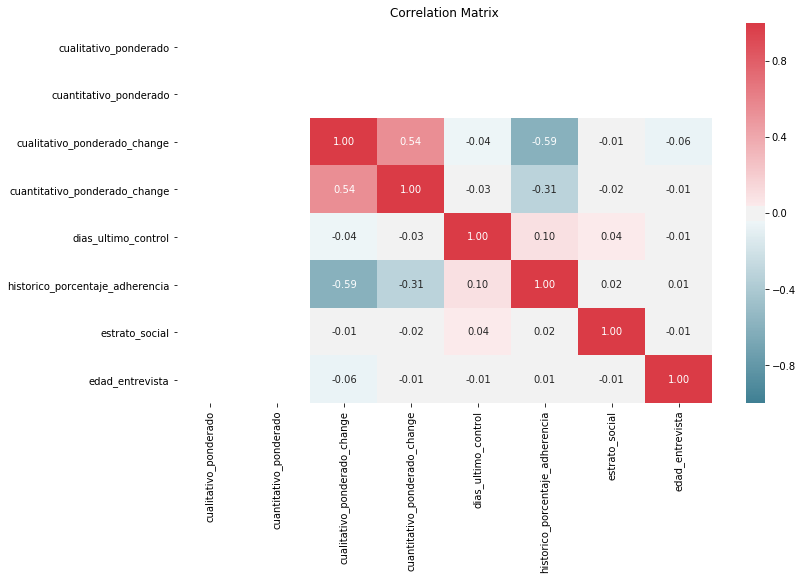

In [48]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_adherent_patients, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


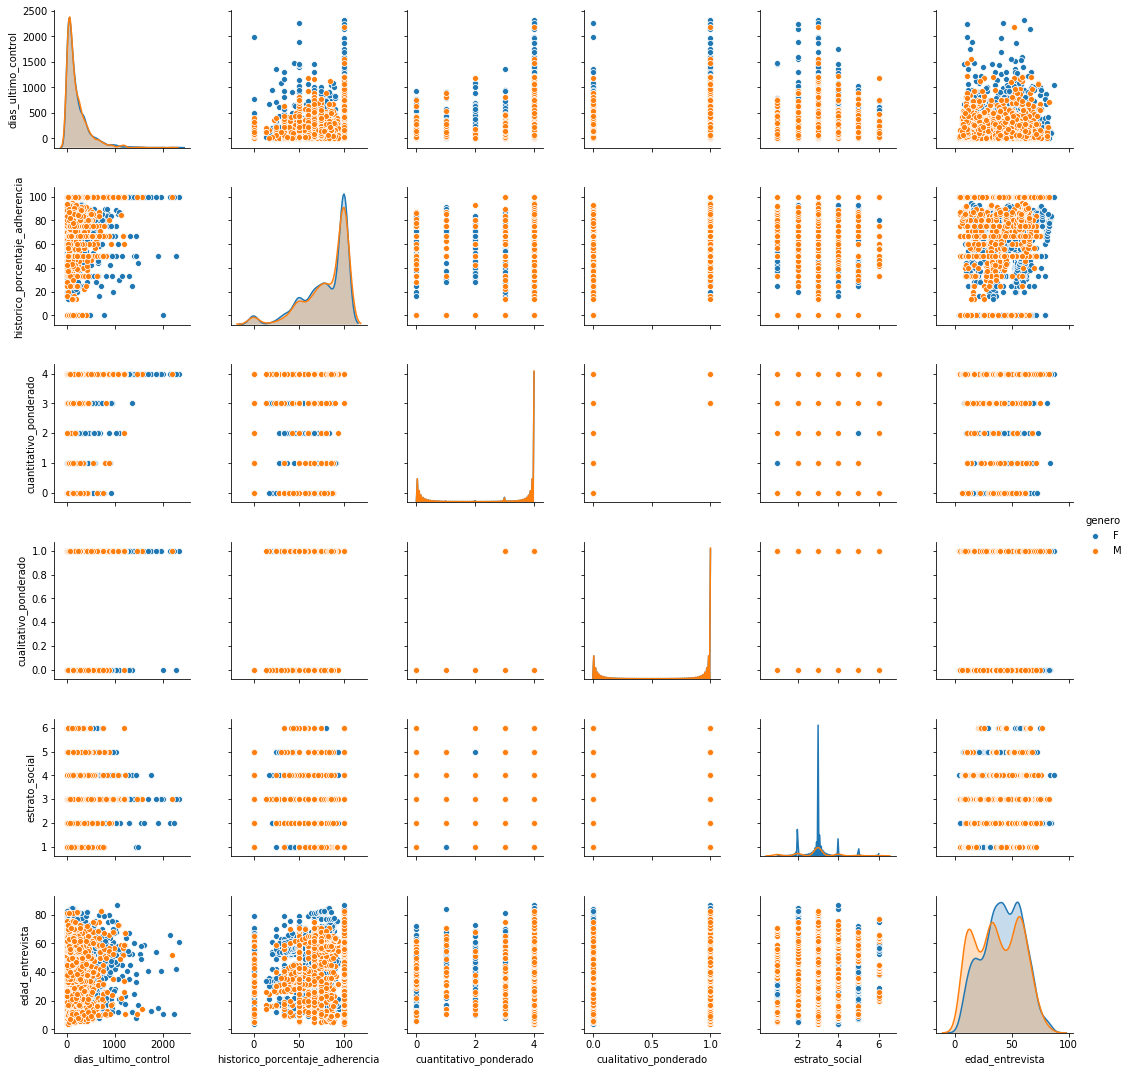

In [49]:
select_vars=['dias_ultimo_control', 'historico_porcentaje_adherencia', 'cuantitativo_ponderado', 'cualitativo_ponderado', 'estrato_social', 'edad_entrevista']
sns.pairplot(basic_info_adherence, vars=select_vars, hue='genero', dropna=True)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


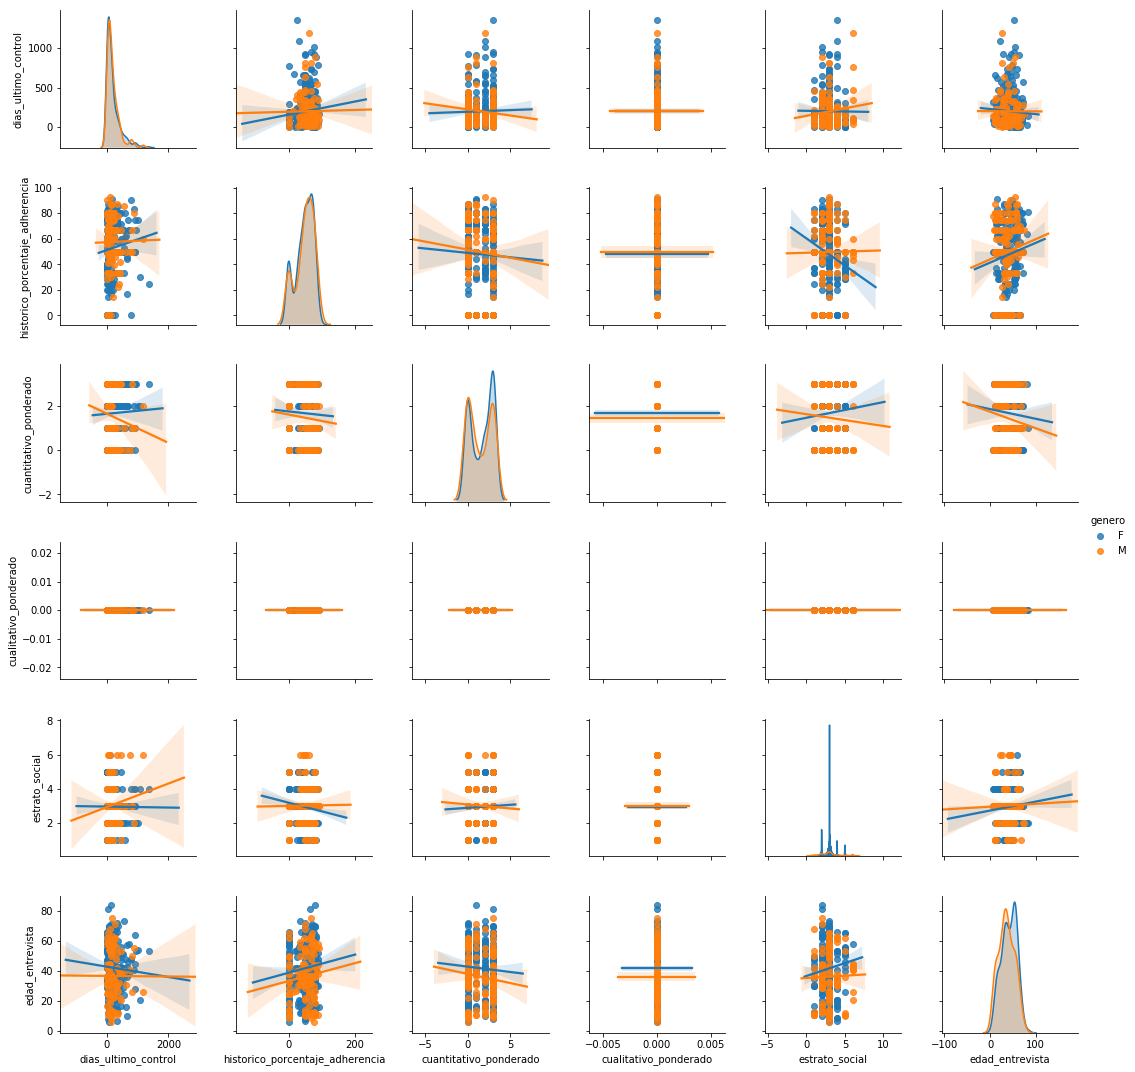

In [50]:
select_vars=['dias_ultimo_control', 'historico_porcentaje_adherencia', 'cuantitativo_ponderado', 'cualitativo_ponderado', 'estrato_social', 'edad_entrevista']
sns.pairplot(basic_info_non_adherent_patients, vars=select_vars, kind='reg', hue='genero')

In [51]:
print(basic_info_adherent_patients.shape)
print(basic_info_non_adherent_patients.shape)


(3765, 26)
(442, 26)


In [52]:
balanced_sample = pd.concat([basic_info_adherent_patients.sample(basic_info_non_adherent_patients.shape[0]), basic_info_non_adherent_patients], ignore_index=True)

In [53]:
display(balanced_sample.head(10))
balanced_sample.shape

,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia,id_paciente,edad,...,zona,acompanante,nivel_socioeconomico,ocupacion,regimen,tipo_afiliacion,relacion_laboral,fecha_nacimiento,grupo_edad,edad_entrevista
0,2019-09-13,A,1,4,0.0,0.0,1068.0,100.00,1874742,73.0,...,URBANA,PAREJA,B,JUBILADO,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1946-11-26,8.0,73
1,2017-05-03,M,1,4,0.0,0.0,63.0,72.73,1479905,45.0,...,URBANA,PAREJA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1974-08-21,5.0,43
2,2019-04-30,M,1,4,1.0,3.0,0.0,66.67,1760796,51.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1968-10-15,6.0,51
3,2016-09-27,A,1,4,0.0,0.0,25.0,100.00,692765,59.0,...,URBANA,PAREJA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1961-03-30,6.0,56
4,2019-01-10,A,1,4,NaN,NaN,NaN,100.00,725396,35.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1985-03-17,4.0,34
5,2015-03-16,M,1,4,NaN,NaN,NaN,100.00,1744661,66.0,...,URBANA,HIJO(A),B,PENSIONADO,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1953-10-01,7.0,62
6,2018-04-19,N+,1,4,1.0,4.0,433.0,46.15,1524020,41.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1978-12-05,5.0,40
7,2016-08-08,N+,1,4,0.0,0.0,96.0,66.67,1196034,60.0,...,URBANA,FAMILIAR CERCANO,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1960-01-15,6.0,57
8,2019-07-22,M,1,4,0.0,0.0,54.0,61.54,738900,37.0,...,URBANA,PAREJA,A,AMA DE CASA,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1982-12-24,4.0,37
9,2014-02-18,M,1,4,NaN,NaN,NaN,100.00,1617372,48.0,...,URBANA,MADRE,A,AMA DE CASA,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1971-07-28,5.0,43


(884, 26)

In [54]:
corr_balanced_sample = balanced_sample.loc[:, ~balanced_sample.columns.isin(['id_paciente', 'edad', 'grupo_edad', 'cualitativo_ponderado_change', 'cuantitativo_ponderado_change'])].corr()

Text(0.5,1,'Correlation Matrix')

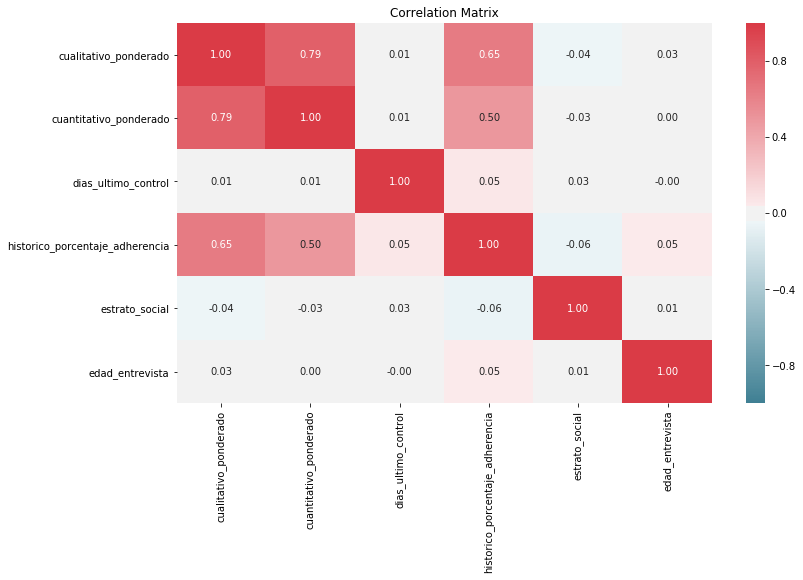

In [55]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_balanced_sample, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

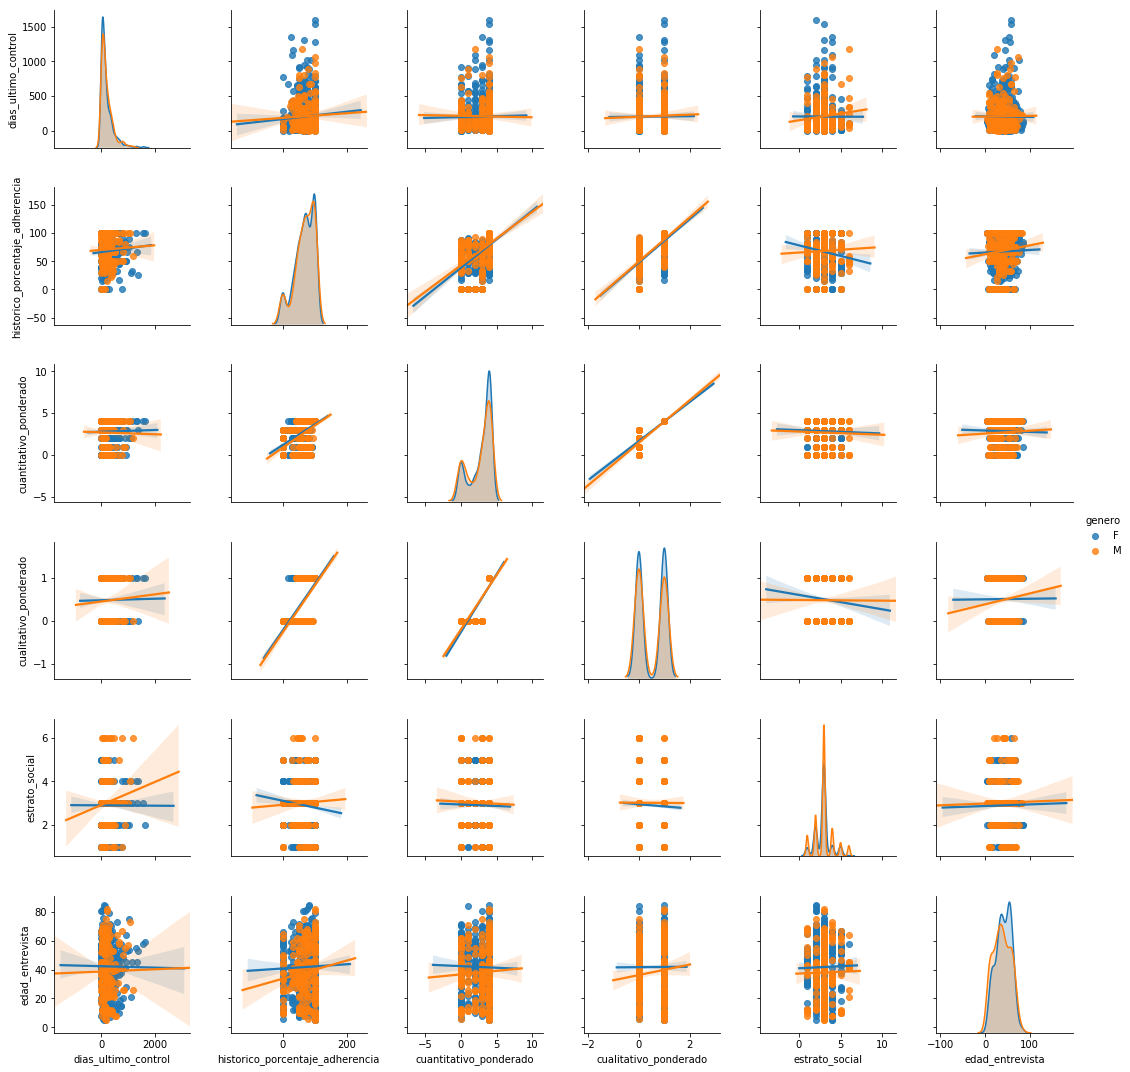

In [56]:
select_vars=['dias_ultimo_control', 'historico_porcentaje_adherencia', 'cuantitativo_ponderado', 'cualitativo_ponderado', 'estrato_social', 'edad_entrevista']
sns.pairplot(balanced_sample, vars=select_vars, hue='genero', kind='reg')

In [57]:
balanced_sample.dtypes

fe_entrevista                      datetime64[ns]
categoria                                category
cualitativo_ponderado                       int64
cuantitativo_ponderado                      int64
cualitativo_ponderado_change              float64
cuantitativo_ponderado_change             float64
dias_ultimo_control                       float64
historico_porcentaje_adherencia           float64
id_paciente                                 int64
edad                                      float64
genero                                   category
escolaridad                              category
estado_civil                             category
departamento                               object
ciudad                                     object
estrato_social                            float64
zona                                     category
acompanante                                object
nivel_socioeconomico                     category
ocupacion                                category


In [74]:
basic_info_adherence['regimen'].cat.categories

Index(['CONTRIBUTIVO', 'OTRO', 'PARTICULAR', 'SUBSIDIADO'], dtype='object')

# Adherencia vs Escolaridad

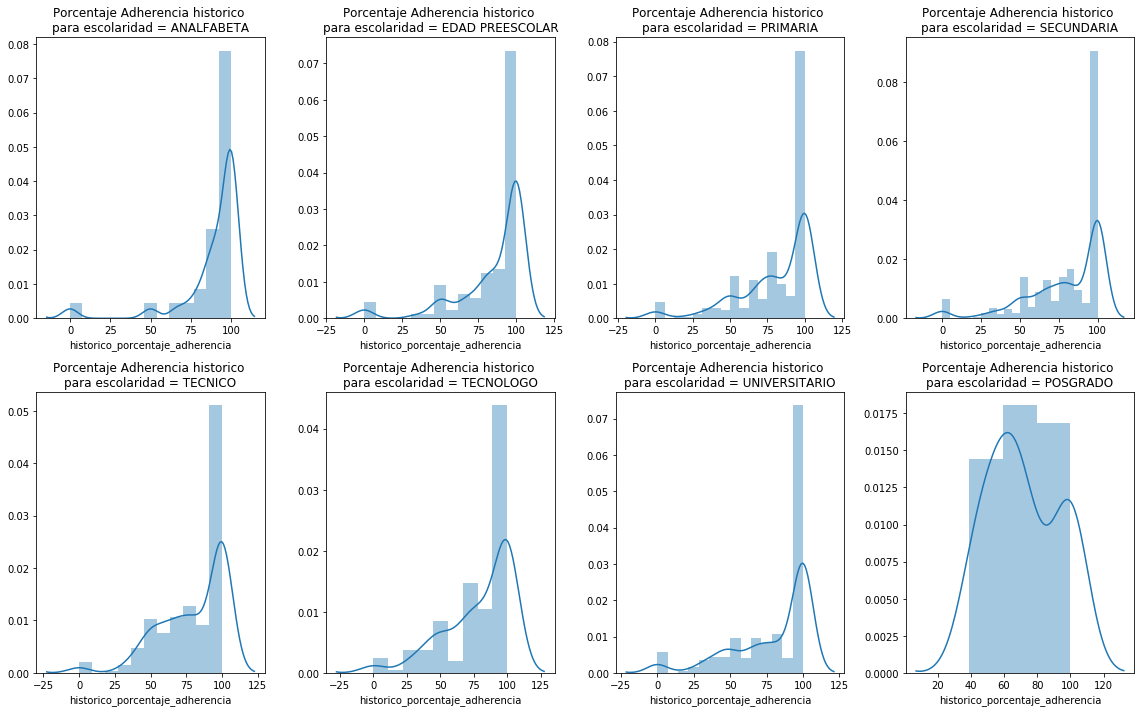

In [59]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['escolaridad'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['escolaridad'] == level),'historico_porcentaje_adherencia'], label=level)
    plt.title("Porcentaje Adherencia historico \npara escolaridad = " + str(level));

plt.tight_layout()

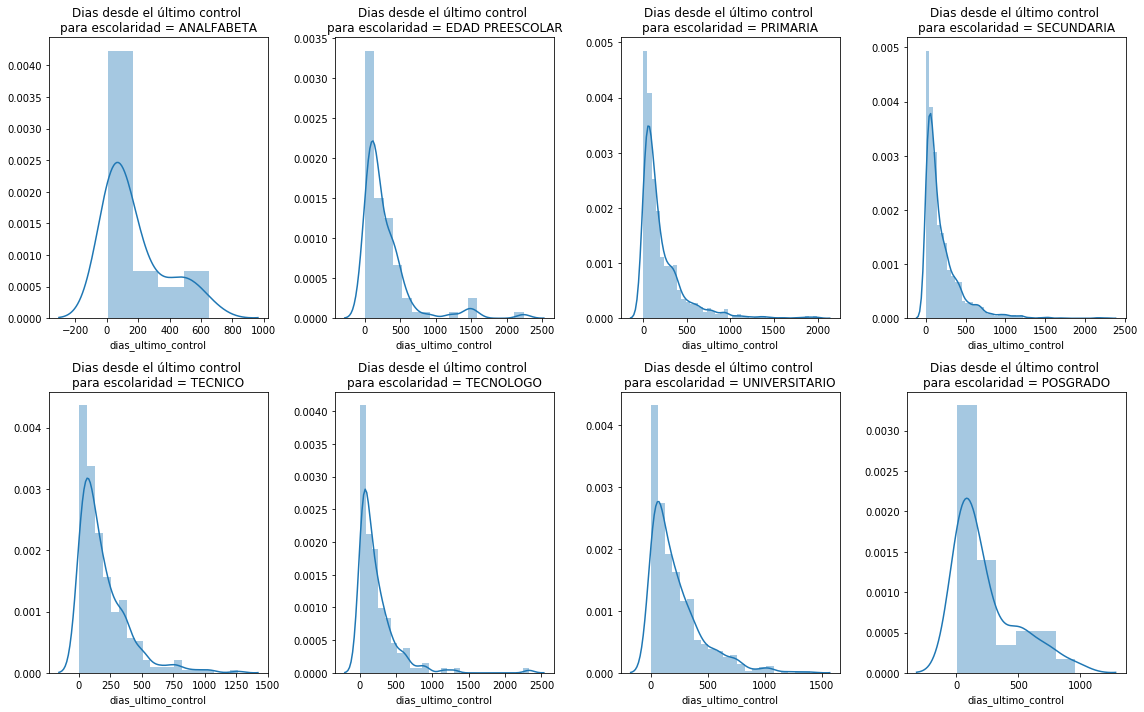

In [60]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['escolaridad'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['escolaridad'] == level),'dias_ultimo_control'].dropna(), label=level)
    plt.title("Dias desde el último control \npara escolaridad = " + str(level));

plt.tight_layout()

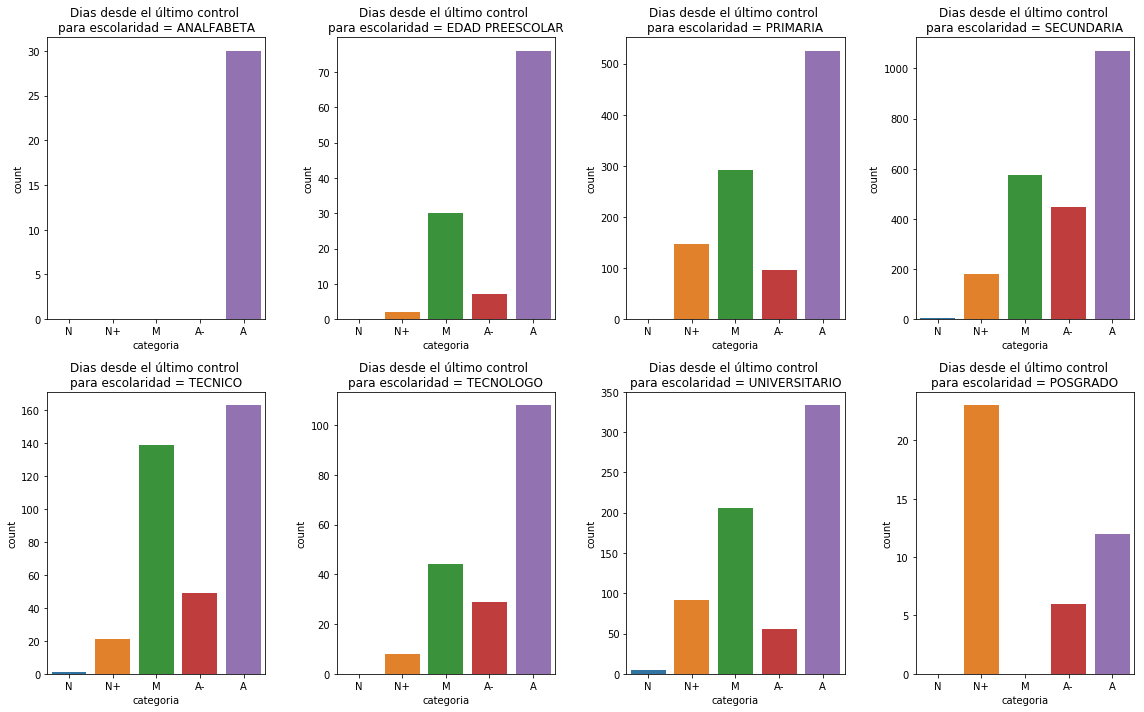

In [126]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['escolaridad'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['escolaridad'] == level)].groupby('categoria').size().reset_index(name='count'), x='categoria', y='count', label=level)
    plt.title("Dias desde el último control \npara escolaridad = " + str(level));

plt.tight_layout()

# Adherencia vs Zona (Urbana/Rural)

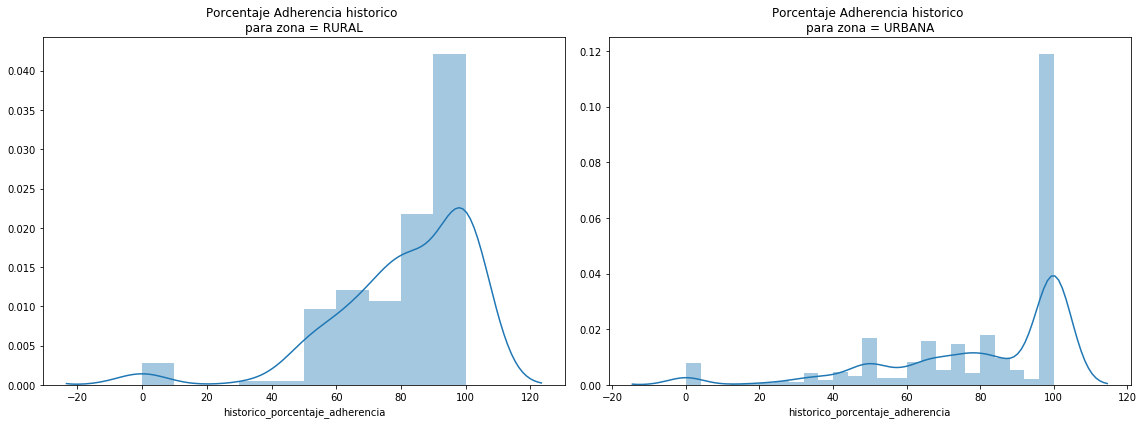

In [62]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zona'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['zona'] == level),'historico_porcentaje_adherencia'], label=level)
    plt.title("Porcentaje Adherencia historico \npara zona = " + str(level));

plt.tight_layout()

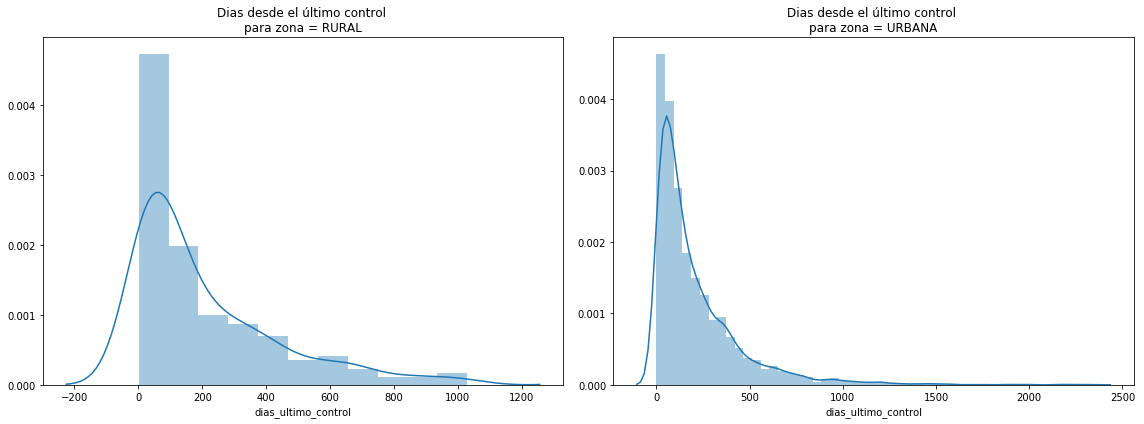

In [63]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zona'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['zona'] == level),'dias_ultimo_control'].dropna(), label=level)
    plt.title("Dias desde el último control \npara zona = " + str(level));

plt.tight_layout()

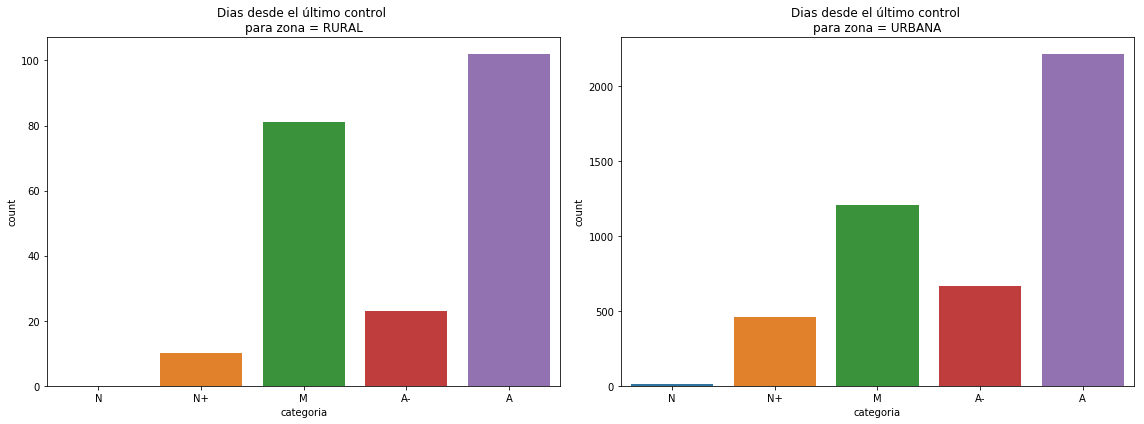

In [127]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zona'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['zona'] == level)].groupby('categoria').size().reset_index(name='count'), x='categoria', y='count', label=level)
    plt.title("Dias desde el último control \npara zona = " + str(level));

plt.tight_layout()

# Adherencia vs Nivel socioeconomico

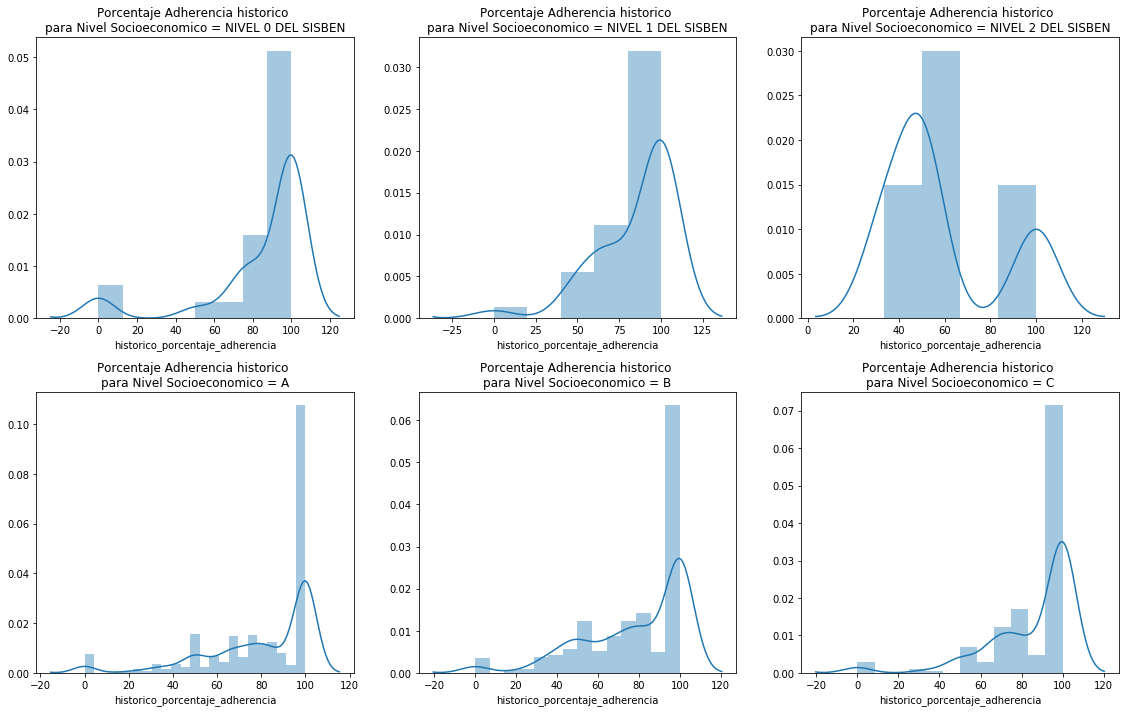

In [65]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['nivel_socioeconomico'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['nivel_socioeconomico'] == level),'historico_porcentaje_adherencia'], label=level)
    plt.title("Porcentaje Adherencia historico \npara Nivel Socioeconomico = " + str(level));

plt.tight_layout()

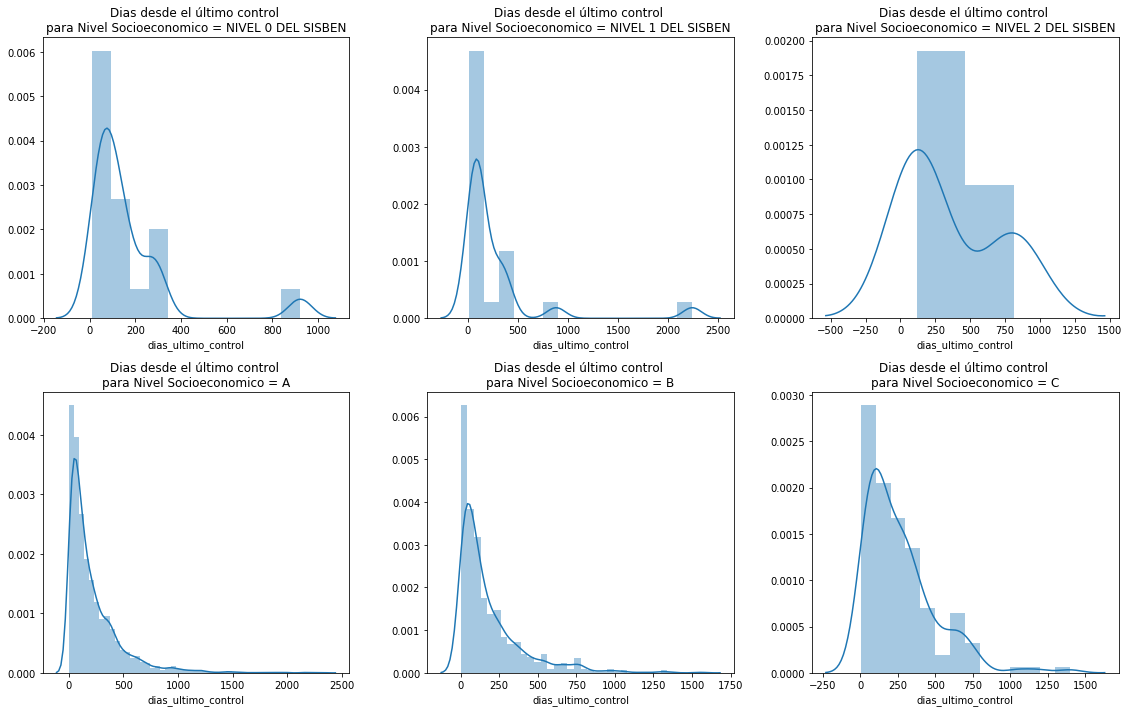

In [66]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['nivel_socioeconomico'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['nivel_socioeconomico'] == level),'dias_ultimo_control'].dropna(), label=level)
    plt.title("Dias desde el último control \npara Nivel Socioeconomico = " + str(level));

plt.tight_layout()

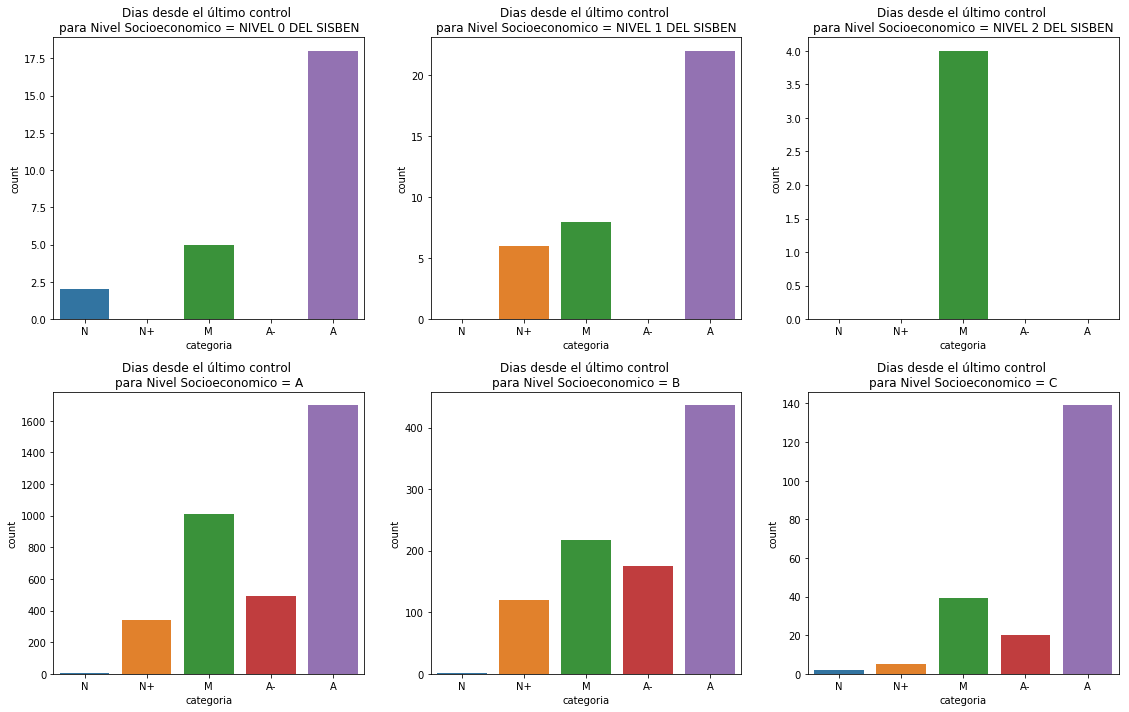

In [128]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['nivel_socioeconomico'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['nivel_socioeconomico'] == level)].groupby('categoria').size().reset_index(name='count'), x='categoria', y='count', label=level)
    plt.title("Dias desde el último control \npara Nivel Socioeconomico = " + str(level));

plt.tight_layout()

# Adherencia vs Ocupacion

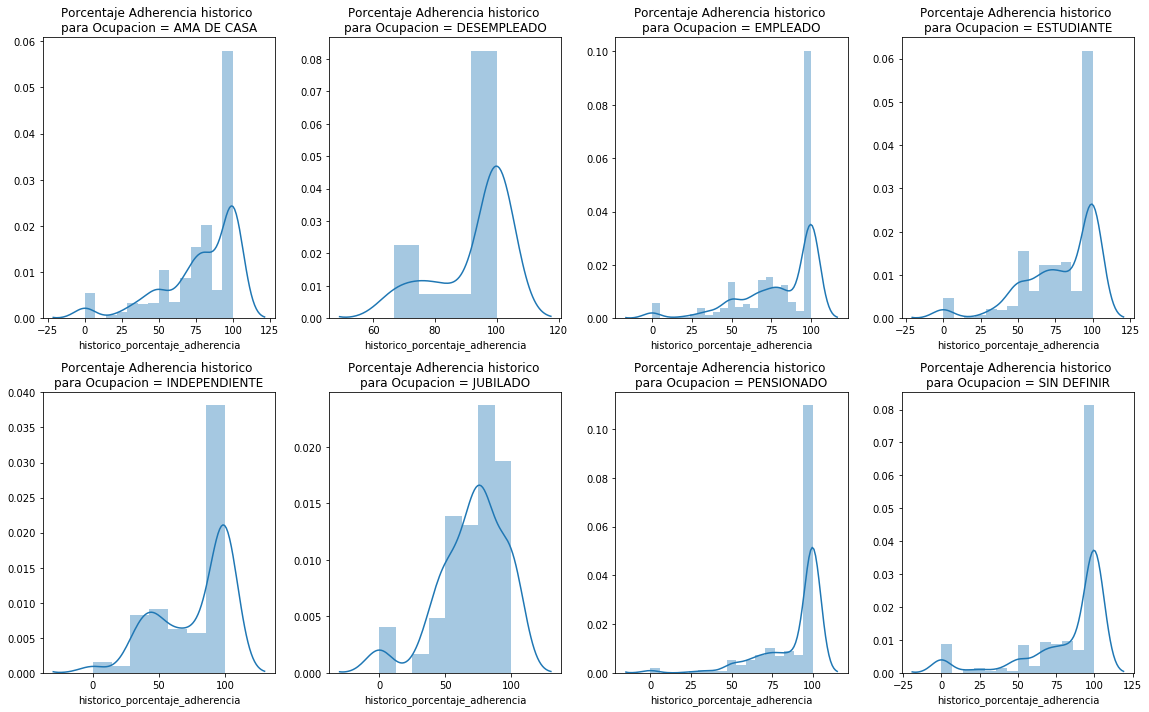

In [70]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['ocupacion'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['ocupacion'] == level),'historico_porcentaje_adherencia'], label=level)
    plt.title("Porcentaje Adherencia historico \npara Ocupacion = " + str(level));

plt.tight_layout()

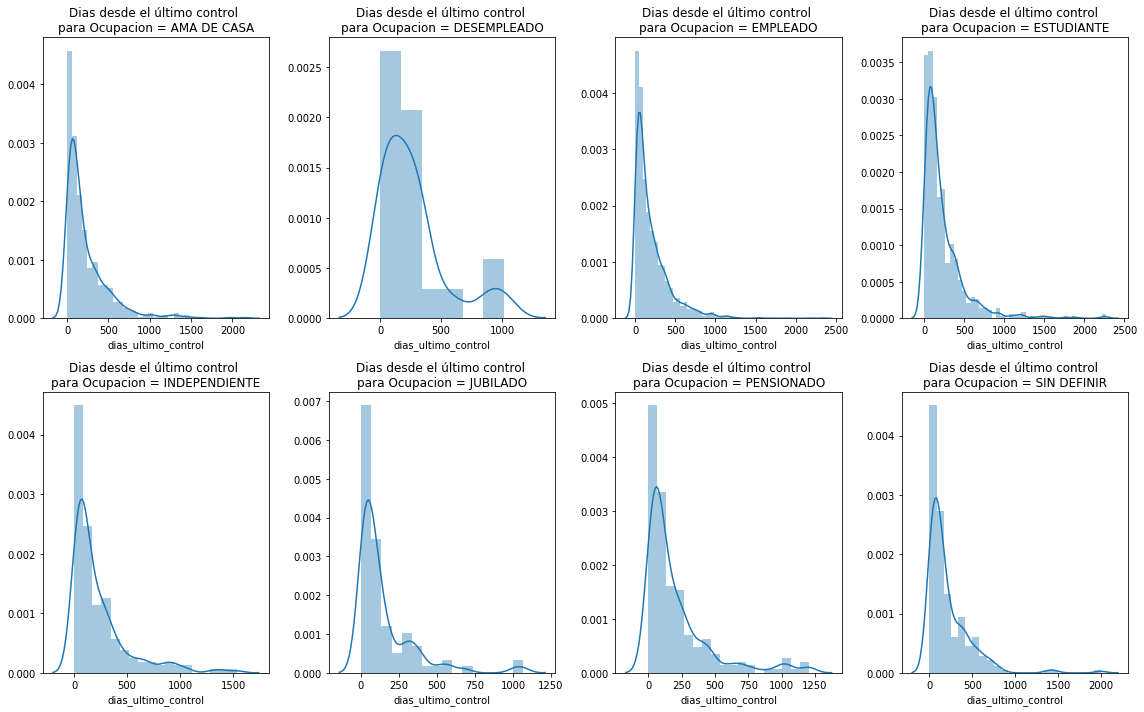

In [71]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['ocupacion'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['ocupacion'] == level),'dias_ultimo_control'].dropna(), label=level)
    plt.title("Dias desde el último control \npara Ocupacion = " + str(level));

plt.tight_layout()

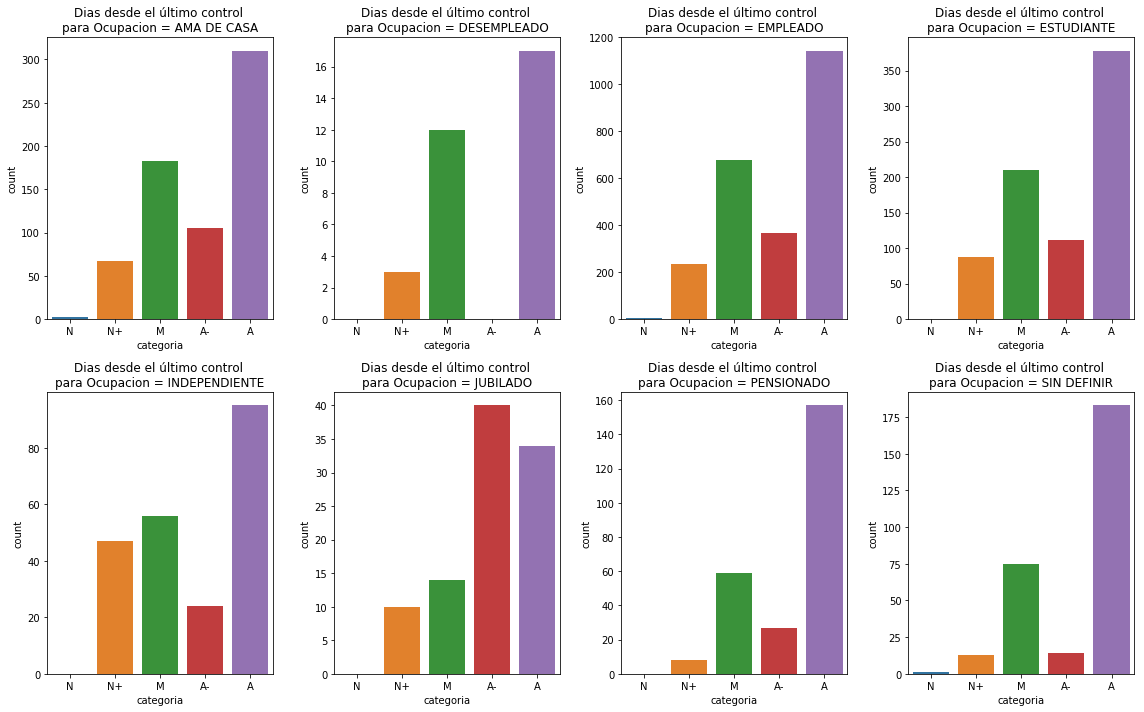

In [129]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['ocupacion'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['ocupacion'] == level)].groupby('categoria').size().reset_index(name='count'), x='categoria', y='count', label=level)
    plt.title("Dias desde el último control \npara Ocupacion = " + str(level));

plt.tight_layout()

# Adherencia vs Regimen

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


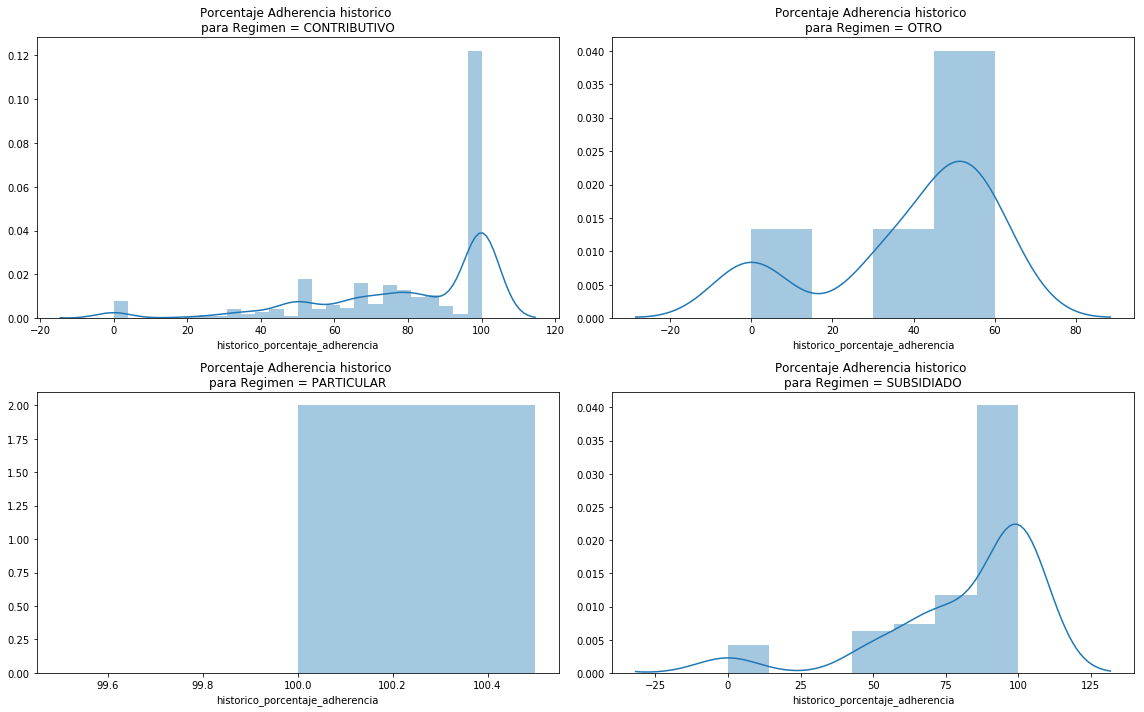

In [76]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['regimen'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['regimen'] == level),'historico_porcentaje_adherencia'], label=level)
    plt.title("Porcentaje Adherencia historico \npara Regimen = " + str(level));

plt.tight_layout()

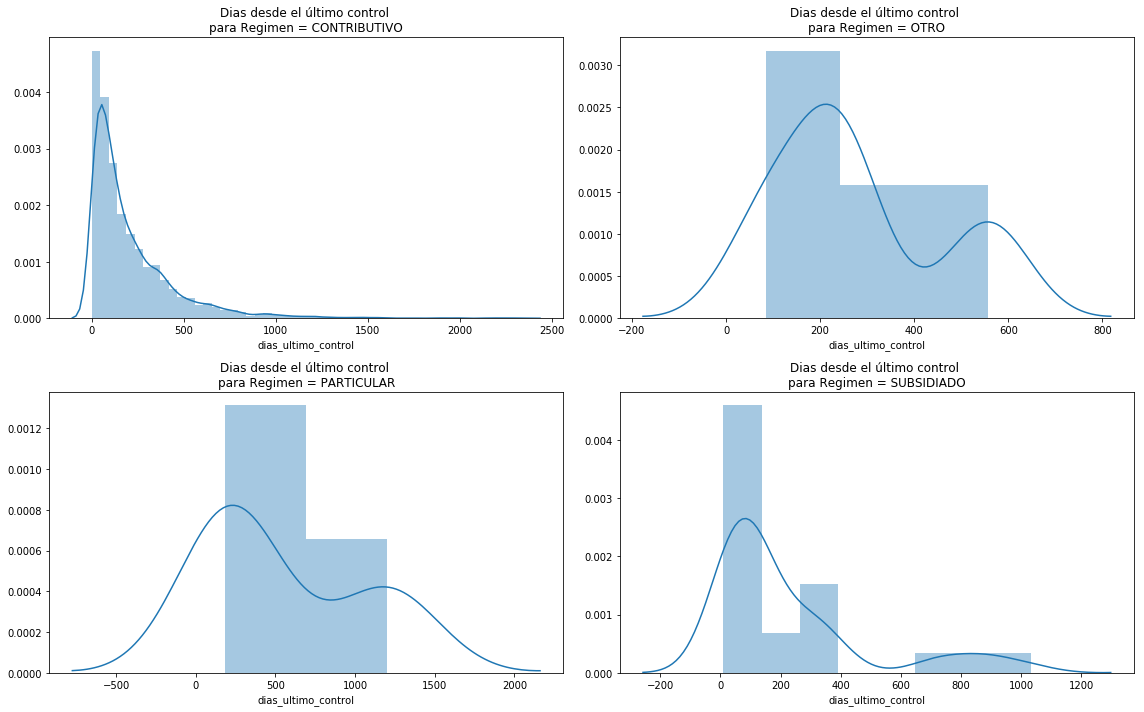

In [79]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['regimen'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['regimen'] == level),'dias_ultimo_control'].dropna(), label=level)
    plt.title("Dias desde el último control \npara Regimen = " + str(level));

plt.tight_layout()

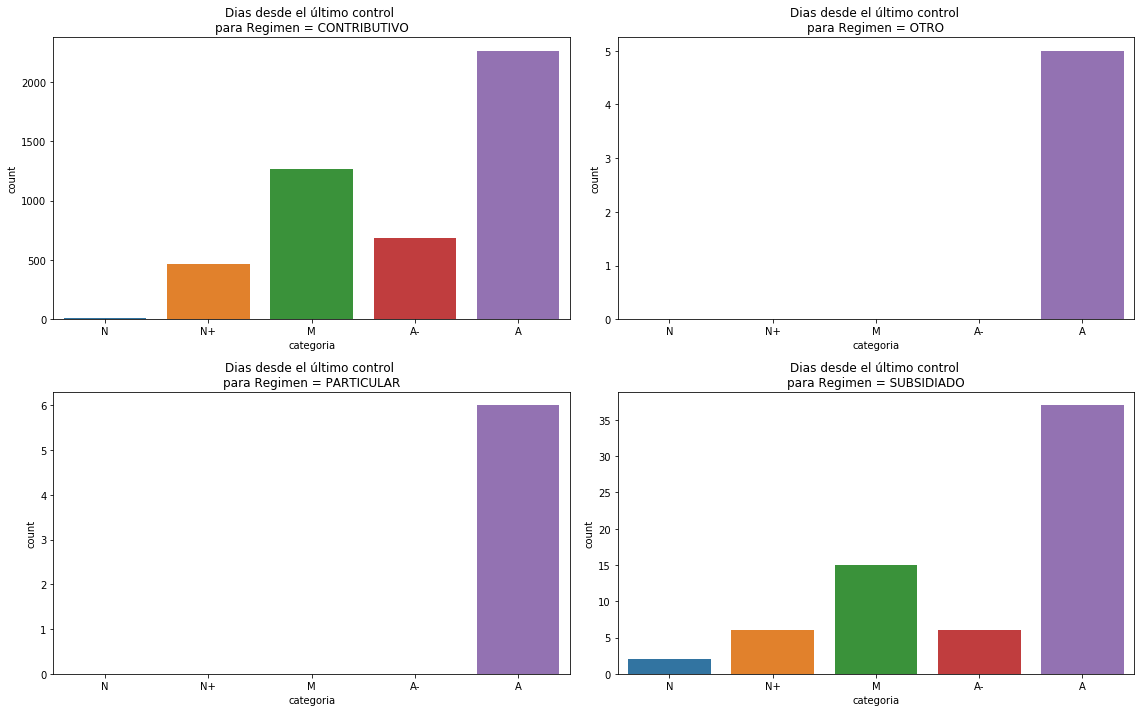

In [130]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['regimen'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['regimen'] == level)].groupby('categoria').size().reset_index(name='count'), x='categoria', y='count', label=level)
    plt.title("Dias desde el último control \npara Regimen = " + str(level));

plt.tight_layout()

# Edad entrevista vs Porcentaje historico adherencia

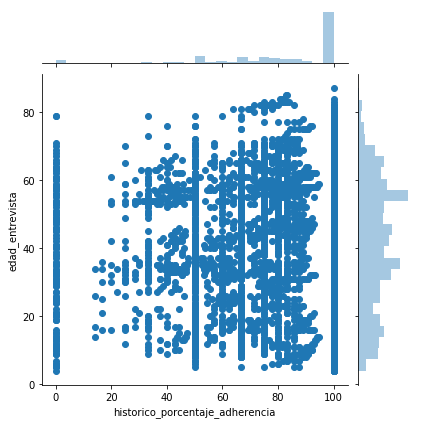

In [97]:
ax = sns.jointplot("historico_porcentaje_adherencia", "edad_entrevista", data=basic_info_adherence)

In [131]:
basic_info_non_adherent_patients.head(10)

,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia,id_paciente,edad,...,zona,acompanante,nivel_socioeconomico,ocupacion,regimen,tipo_afiliacion,relacion_laboral,fecha_nacimiento,grupo_edad,edad_entrevista
8,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
11,2015-01-07,M,0,3,0.0,-1.0,47.0,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
12,2015-01-14,M,0,3,0.0,0.0,7.0,0.00,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
14,2016-01-12,M,0,3,-1.0,-1.0,201.0,14.29,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26
16,2017-01-03,M,0,3,-1.0,-1.0,354.0,22.22,502989,29.0,...,URBANA,MADRE,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,27
36,2019-02-21,M,0,0,0.0,-4.0,136.0,80.00,506808,11.0,...,URBANA,MADRE,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06,2.0,11
48,2019-09-30,M,0,1,-1.0,-3.0,293.0,72.73,512938,22.0,...,URBANA,PACIENTE,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15,3.0,22
62,2017-05-10,A-,0,3,-1.0,-1.0,28.0,70.00,524006,67.0,...,URBANA,HIJO(A),A,PENSIONADO,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1952-08-10,7.0,65
94,2019-02-14,A-,0,3,0.0,-1.0,380.0,57.14,529410,22.0,...,RURAL,MADRE,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,1998-01-21,3.0,22


Text(0.5,0,'Social stratum classification')

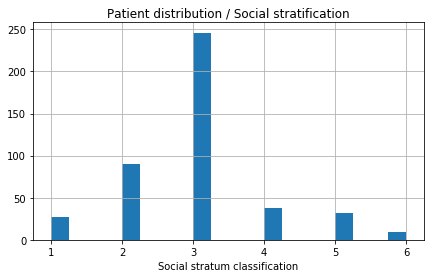

In [116]:
plt.figure(figsize=(7,4))
basic_info_non_adherent_patients['estrato_social'].hist(bins=20)
plt.title("Patient distribution / Social stratification")
plt.xlabel("Social stratum classification")

In [117]:
count_per_depto = basic_info_non_adherent_patients[['id_paciente', 'departamento']].groupby('departamento').count().reset_index()
count_per_depto.columns = ['departamento', 'count_pacientes']
count_per_depto['percentage'] = (count_per_depto['count_pacientes'] / sum(count_per_depto['count_pacientes']))*100
count_per_depto.sort_values(by='count_pacientes', ascending=False).set_index('departamento')

,count_pacientes,percentage
departamento,,
ANTIOQUIA,407,92.081448
ATLANTICO,13,2.941176
VALLE DEL CAUCA,9,2.036199
SANTAFE DE BOGOTA D.C,6,1.357466
CALDAS,5,1.131222
CUNDINAMARCA,2,0.452489


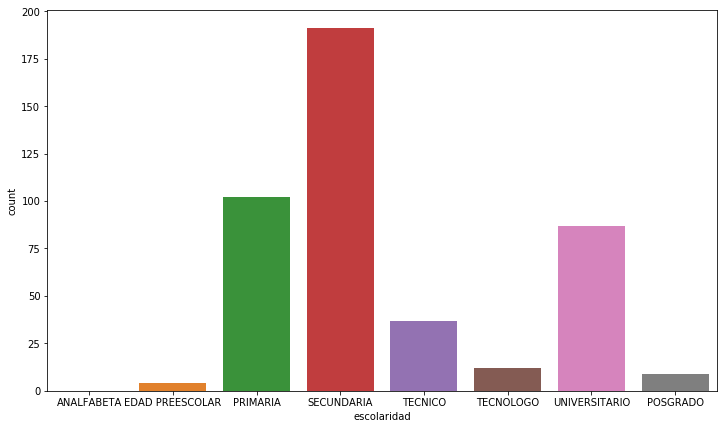

In [132]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('escolaridad').size().reset_index(name='count'), x='escolaridad', y='count', ax=ax)

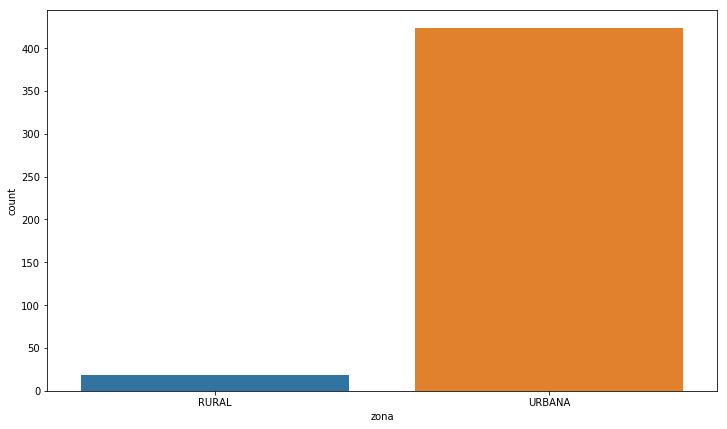

In [133]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('zona').size().reset_index(name='count'), x='zona', y='count', ax=ax)

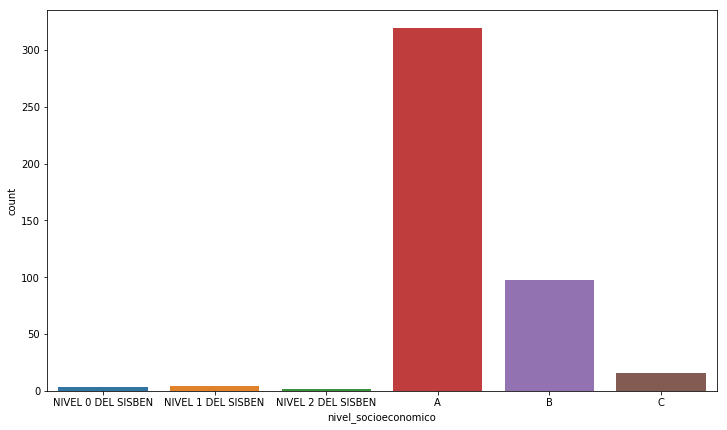

In [136]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('nivel_socioeconomico').size().reset_index(name='count'), x='nivel_socioeconomico', y='count', ax=ax)

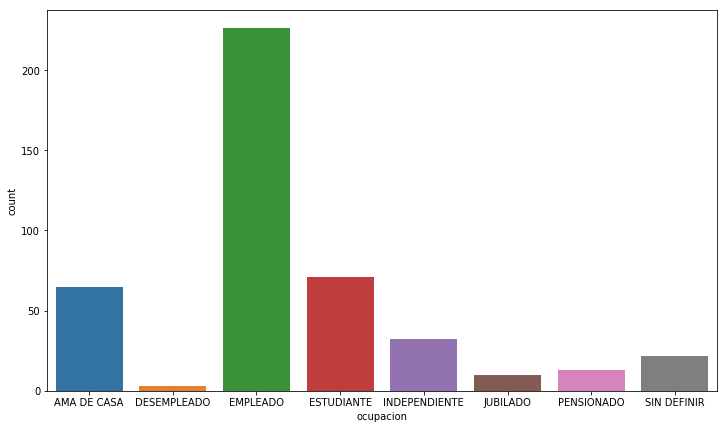

In [138]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('ocupacion').size().reset_index(name='count'), x='ocupacion', y='count', ax=ax)

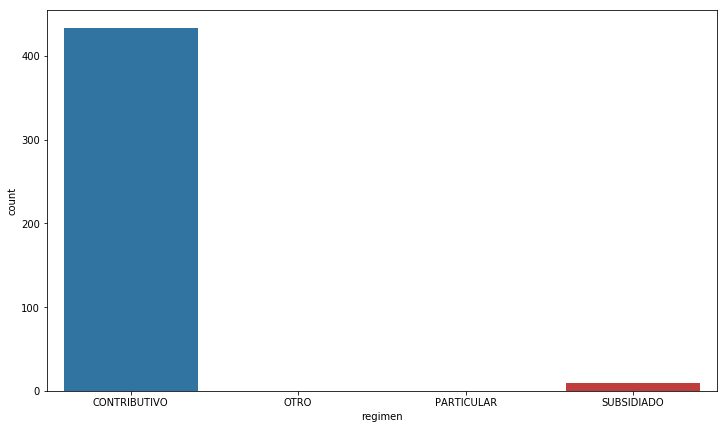

In [135]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('regimen').size().reset_index(name='count'), x='regimen', y='count', ax=ax)

Text(0.5,0,'Age')

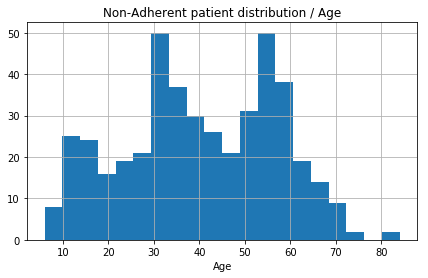

In [140]:
plt.figure(figsize=(7,4))
basic_info_non_adherent_patients['edad_entrevista'].hist(bins=20)
plt.title("Non-Adherent patient distribution / Age")
plt.xlabel("Age")